In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so

from pymutspec.draw import plot_mutspec12
from pymutspec.annotation import CodonAnnotation
from pymutspec.constants import possible_codons
from pymutspec.io import read_genbank_ref

from scipy.stats import chisquare, ks_2samp, pearsonr, spearmanr, uniform
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error, r2_score
import tqdm

from utils import (
    amino_acid_codes, alphabet, cdn_spectrum_to_matrix, 
    nuc_spectrum_to_matrix, collect_possible_changes,
    get_equilibrium_probabilities, plot_exp_heatmap,
    prepare_aa_subst, plot_aa_eq_freqs, prepare_exp_aa_subst,
    calc_metrics,weighted_average_percentage_error
)

In [2]:
coda = CodonAnnotation(1)

## Load reference and calc amino acid freqs

In [3]:
from Bio import SeqIO
rec = next(SeqIO.parse("data/NC_045512.2.gb", "genbank"))

In [4]:
ref_df = pd.DataFrame([f.qualifiers for f in rec.features if f.type == "CDS"])
ref_df.drop(columns=["locus_tag", "ribosomal_slippage", "codon_start", 
                     "db_xref", 'gene_synonym'], inplace=True)
ref_df["gene"] = ref_df["gene"].apply(lambda x: x[0])
ref_df["product"] = ref_df["product"].apply(lambda x: x[0])
ref_df["protein_id"] = ref_df["protein_id"].apply(lambda x: x[0])
ref_df["translation"] = ref_df["translation"].apply(lambda x: x[0])
ref_df = ref_df[ref_df['product'] != 'ORF1a polyprotein']
ref_df.to_csv('./data/ref_proteins.csv', index=False)
ref_df

,gene,note,product,protein_id,translation
0,ORF1ab,[pp1ab; translated by -1 ribosomal frameshift],ORF1ab polyprotein,YP_009724389.1,MESLVPGFNEKTHVQLSLPVLQVRDVLVRGFGDSVEEVLSEARQHL...
2,S,[structural protein; spike protein],surface glycoprotein,YP_009724390.1,MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSS...
3,ORF3a,NaN,ORF3a protein,YP_009724391.1,MDLFMRIFTIGTVTLKQGEIKDATPSDFVRATATIPIQASLPFGWL...
4,E,[ORF4; structural protein; E protein],envelope protein,YP_009724392.1,MYSFVSEETGTLIVNSVLLFLAFVVFLLVTLAILTALRLCAYCCNI...
5,M,[ORF5; structural protein],membrane glycoprotein,YP_009724393.1,MADSNGTITVEELKKLLEQWNLVIGFLFLTWICLLQFAYANRNRFL...
6,ORF6,NaN,ORF6 protein,YP_009724394.1,MFHLVDFQVTIAEILLIIMRTFKVSIWNLDYIINLIIKNLSKSLTE...
7,ORF7a,NaN,ORF7a protein,YP_009724395.1,MKIILFLALITLATCELYHYQECVRGTTVLLKEPCSSGTYEGNSPF...
8,ORF7b,NaN,ORF7b,YP_009725318.1,MIELSLIDFYLCFLAFLLFLVLIMLIIFWFSLELQDHNETCHA
9,ORF8,NaN,ORF8 protein,YP_009724396.1,MKFLVFLGIITTVAAFHQECSLQSCTQHQPYVVDDPCPIHFYSKWY...
10,N,[ORF9; structural protein],nucleocapsid phosphoprotein,YP_009724397.2,MSDNGPQNQRNAPRITFGGPSDSTGSNQNGERSGARSKQRRPQGLP...


In [5]:
aa_freqs_df = pd.DataFrame(ref_df.set_index('gene')['translation']\
                           .apply(Counter).to_dict()).T.fillna(0).astype(int)
aa_freqs_df.to_csv('./data/ref_aa_freqs.csv')
aa_freqs_df

,M,E,S,L,V,P,G,F,N,K,T,H,Q,R,D,A,C,Y,I,W
ORF1ab,168,340,456,668,598,274,412,349,384,434,527,145,239,244,389,487,226,335,343,78
S,14,48,99,108,97,58,82,77,88,61,97,17,62,42,62,79,40,54,76,12
ORF3a,4,11,22,30,25,12,14,14,8,11,24,8,9,6,13,13,7,17,21,6
E,1,2,8,14,13,2,1,5,5,2,4,0,0,3,1,4,3,4,3,0
M,4,7,15,35,12,5,14,11,11,7,13,5,4,14,6,19,4,9,20,7
ORF6,3,5,4,8,3,1,0,3,4,4,3,1,3,1,4,1,0,2,10,1
ORF7a,1,8,7,15,8,6,4,10,2,7,10,3,5,5,2,9,6,5,8,0
ORF7b,2,3,2,11,1,0,0,6,1,0,1,2,1,0,2,2,2,1,5,1
ORF8,1,6,9,10,12,7,5,8,2,5,5,4,6,4,7,5,7,7,10,1
N,7,12,37,27,8,28,43,13,22,31,32,4,35,29,24,37,0,11,14,5


In [6]:
aa_freqs_total_dct = aa_freqs_df.rename(columns=amino_acid_codes).sum(0).to_dict()
aa_freqs_total_dct

{'Met': 207,
 'Glu': 442,
 'Ser': 661,
 'Leu': 930,
 'Val': 781,
 'Pro': 394,
 'Gly': 576,
 'Phe': 500,
 'Asn': 532,
 'Lys': 562,
 'Thr': 718,
 'His': 189,
 'Gln': 365,
 'Arg': 350,
 'Asp': 511,
 'Ala': 658,
 'Cys': 296,
 'Tyr': 448,
 'Ile': 513,
 'Trp': 111}

## Load spectrum and calculate expected AA subst matrix and equilibrium

In [7]:
## read external clades spectra
# https://raw.githubusercontent.com/jbloomlab/SARS2-mut-spectrum/refs/heads/main/results/synonymous_mut_rates/rates_by_clade.csv

clades_spectra = pd.read_csv('data/bloom_etal/rates_by_clade.csv').query('subset == "all"')
clades_spectra['Mut'] = clades_spectra['mut_type'].str.replace('to', '>')
spectrum_20A = clades_spectra[clades_spectra['clade'] == '20A'].copy()
spectrum_20A['rate'] /= spectrum_20A['rate'].sum()
spectrum_20A

,subset,clade,mut_type,count,total_count,fraction,parent_nt,parent_nt_frac,rate,Mut
0,all,20A,AtoC,305,18970,0.016078,A,0.289560,0.007540,A>C
1,all,20A,AtoG,1778,18970,0.093727,A,0.289560,0.043953,A>G
2,all,20A,AtoT,588,18970,0.030996,A,0.289560,0.014536,A>T
3,all,20A,CtoA,384,18970,0.020242,C,0.135130,0.020341,C>A
4,all,20A,CtoG,135,18970,0.007117,C,0.135130,0.007151,C>G
5,all,20A,CtoT,7840,18970,0.413280,C,0.135130,0.415293,C>T
6,all,20A,GtoA,878,18970,0.046284,G,0.064585,0.097310,G>A
7,all,20A,GtoC,140,18970,0.007380,G,0.064585,0.015516,G>C
8,all,20A,GtoT,2906,18970,0.153190,G,0.064585,0.322075,G>T
9,all,20A,TtoA,639,18970,0.033685,T,0.510720,0.008956,T>A


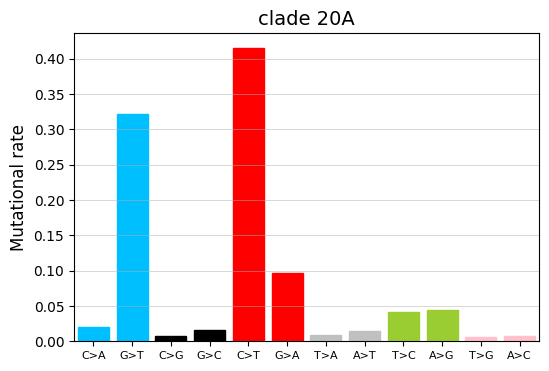

In [8]:
ax = plot_mutspec12(spectrum_20A, 'rate', 'clade 20A', 
               ylabel='Mutational rate', 
            #    savepath='./figures/20A_spectrum.png'
)

In [9]:
spectrum_20A_dct = spectrum_20A.set_index('Mut').rate.to_dict()
df_changes = collect_possible_changes(1, spectrum_20A_dct)

## Calculate expected AA substitutions matrix
exp_aa_subst = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
    .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
exp_aa_subst.to_csv('data/20A/exp_aa_subst.csv', float_format='%g', index=False)
exp_aa_subst_matrix = exp_aa_subst.pivot(index='aa1', columns='aa2', values='rate').fillna(0.)


## Calculate codon and AA equilibrium frequencies
M = cdn_spectrum_to_matrix(df_changes)
eq_prob = get_equilibrium_probabilities(M).astype(float)

eq_freqs_cdn = pd.Series(dict(zip(possible_codons, eq_prob)))
eq_freqs_cdn.name = 'freq'
eq_freqs_cdn.index.name = 'cdn'
eq_freqs_cdn = eq_freqs_cdn.reset_index()
eq_freqs_cdn['aa'] = eq_freqs_cdn['cdn'].map(coda.translate_codon).map(amino_acid_codes)

eq_freqs_cdn.to_csv('./data/20A/cdn_eq_freqs.csv', index=False, float_format='%g')
eq_freqs_cdn

,cdn,freq,aa
0,AAA,0.003032,Lys
1,AAC,0.003836,Asn
2,AAG,0.001522,Lys
3,AAT,0.012910,Asn
4,ACA,0.003836,Thr
...,...,...,...
59,TGT,0.029462,Cys
60,TTA,0.054818,Leu
61,TTC,0.074299,Phe
62,TTG,0.029462,Leu


In [9]:
exp_aa_subst_matrix

aa2,Ala,Arg,Asn,Asp,Cys,Gln,Glu,Gly,His,Ile,Leu,Lys,Met,Phe,Pro,Ser,Thr,Trp,Tyr,Val
aa1,,,,,,,,,,,,,,,,,,,,
Ala,1.000000,0.000000,0.000000,0.040682,0.000000,0.000000,0.040682,0.028605,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062066,1.288299,0.389238,0.000000,0.000000,1.661172
Arg,0.000000,1.197024,0.000000,0.000000,0.830586,0.194619,0.000000,0.116511,0.194619,0.322075,1.288299,0.194619,0.322075,0.000000,0.062066,0.400349,0.031033,0.429829,0.000000,0.000000
Asn,0.000000,0.000000,0.456105,0.087906,0.000000,0.000000,0.000000,0.000000,0.015079,0.029072,0.000000,0.042965,0.000000,0.000000,0.000000,0.087906,0.015079,0.000000,0.029072,0.000000
Asp,0.015079,0.000000,0.194619,0.456105,0.000000,0.000000,0.042965,0.087906,0.031033,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.644149,0.029072
Cys,0.000000,0.081625,0.000000,0.000000,0.456105,0.000000,0.000000,0.013034,0.000000,0.000000,0.000000,0.000000,0.000000,0.644149,0.000000,0.048945,0.000000,0.013668,0.194619,0.000000
Gln,0.000000,0.087906,0.000000,0.000000,0.000000,0.141263,0.014303,0.000000,0.359667,0.000000,0.029072,0.040682,0.000000,0.000000,0.015079,0.000000,0.000000,0.000000,0.000000,0.000000
Glu,0.015079,0.000000,0.000000,0.359667,0.000000,0.031033,0.141263,0.087906,0.000000,0.000000,0.000000,0.194619,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.029072
Gly,0.062066,0.256685,0.000000,0.194619,0.644149,0.000000,0.194619,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.194619,0.000000,0.322075,0.000000,1.288299
His,0.000000,0.087906,0.040682,0.014303,0.000000,0.042965,0.000000,0.000000,0.456105,0.000000,0.029072,0.000000,0.000000,0.000000,0.015079,0.000000,0.000000,0.000000,0.830586,0.000000


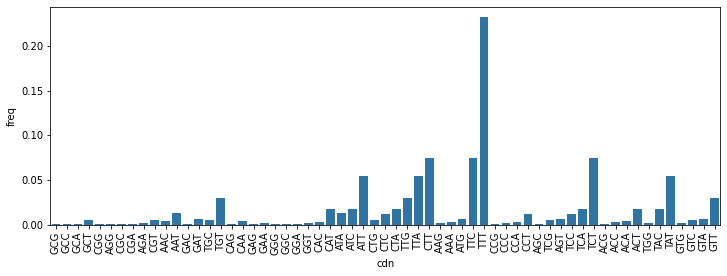

In [104]:
plt.figure(figsize=(12, 4))
sns.barplot(data=eq_freqs_cdn.sort_values(['aa', 'freq']).iloc[3:], 
            y='freq', x='cdn', )
plt.xticks(rotation=90);

In [105]:
aa_flows = df_changes\
    .query('(sbs == "C>T" | sbs == "G>T") & aa1 != "*" & aa2 != "*" & aa1 != aa2')\
    .groupby(['aa1', 'aa2']).rate.count().reset_index()

inflow = aa_flows.groupby('aa2').rate.sum().rename('inflow')
outflow = aa_flows.groupby('aa1').rate.sum().rename('outflow')
inflow.index.name='aa'
outflow.index.name='aa'
_flow = inflow.to_frame().join(outflow, how='outer').fillna(0).astype(int)
_flow['flow'] = _flow['inflow'] - _flow['outflow']
_flow.sort_values('flow')[['flow']].T

aa,Arg,Ala,Pro,Gly,Thr,Glu,His,Gln,Lys,Asp,Trp,Asn,Met,Cys,Ser,Tyr,Val,Ile,Phe,Leu
flow,-10,-8,-8,-7,-4,-1,-1,-1,-1,-1,0,1,1,3,3,4,4,7,9,10


In [106]:
aa_flows.query('aa1 == "Ser" | aa2 == "Ser"')

,aa1,aa2,rate
0,Ala,Ser,4
6,Arg,Ser,1
20,Pro,Ser,4
21,Ser,Ile,2
22,Ser,Leu,2
23,Ser,Phe,2


In [107]:
_flow.sort_values('flow')

,inflow,outflow,flow
aa,,,
Arg,0,10,-10
Ala,0,8,-8
Pro,0,8,-8
Gly,0,7,-7
Thr,0,4,-4
Glu,0,1,-1
His,1,2,-1
Gln,0,1,-1
Lys,0,1,-1


In [108]:
eq_freqs_aa = eq_freqs_cdn[eq_freqs_cdn.aa !='*'].groupby('aa')['freq'].sum()
eq_freqs_aa /= eq_freqs_aa.sum()
eq_freqs_aa = eq_freqs_aa.sort_values(ascending=False).reset_index()
eq_freqs_aa.to_csv('./data/20A/aa_eq_freqs.csv', index=False)
eq_freqs_aa.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
aa,Phe,Leu,Ser,Ile,Tyr,Val,Cys,Thr,His,Pro,Asn,Arg,Asp,Ala,Met,Gln,Lys,Gly,Glu,Trp
freq,0.314637,0.197825,0.119281,0.086898,0.073639,0.044165,0.035283,0.025257,0.020183,0.017862,0.017199,0.009142,0.008012,0.007127,0.006878,0.005073,0.004677,0.002844,0.002015,0.002004


## Load OBS

In [15]:
obs_raw = pd.read_csv('data/bloom_etal/aggregated.csv').query('subset == "all" & exclude == False')
obs = obs_raw.query('synonymous == False & noncoding == False').drop(['synonymous', 'noncoding', 'four_fold_degenerate'], axis=1)

def _same_aa_mut(aa_mutation: str):
    variants = aa_mutation.split(';')
    return variants.count(variants[0]) == len(variants)

obs = obs[obs.aa_mutation.apply(_same_aa_mut)]
obs['aa1'] = obs['aa_mutation'].str[0]
obs['aa2'] = obs['aa_mutation'].str[-1]
# # obs['Mut'] = obs['mut_type'].str.replace('to', '>')
# same as in the paper table
# obs[obs.four_fold_degenerate].groupby('clade')['count'].sum().sort_index()
obs

,protein,aa_mutation,nt_mutation,codon_change,nt_site,reference_nt,clade_founder_nt,exclude,count,count_terminal,count_non_terminal,mean_log_size,clade,subset,codon,codon_position,codon_site,aa1,aa2
0,ORF1ab,P5401L,C16466T,CCA>CTA,16466,C,C,False,70,37,33,0.708825,19A,all,CCA,2,5401,P,L
1,M,I82T,T26767C,ATC>ACC,26767,T,T,False,58,18,40,1.237886,19A,all,ATC,2,82,I,T
3,ORF1ab,P4715L,C14408T,CCT>CTT,14408,C,C,False,52,26,26,0.678436,19A,all,CCT,2,4715,P,L
4,ORF1ab,A6319V,C19220T,GCT>GTT,19220,C,C,False,50,15,35,1.097059,19A,all,GCT,2,6319,A,V
5,ORF1ab,I5658V,A17236G,ATA>GTA,17236,A,A,False,48,24,24,0.581333,19A,all,ATA,1,5658,I,V
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553870,ORF1a;ORF1ab,V4369A;V4369A,T13371C,GTC>GCC;GTC>GCC,13371,T,T,False,1,1,0,0.000000,24E,all,GTC;GTC,2;2,4369;4369,V,A
1553871,ORF1a;ORF1ab,V4350A;V4350A,T13314C,GTA>GCA;GTA>GCA,13314,T,T,False,1,1,0,0.000000,24E,all,GTA;GTA,2;2,4350;4350,V,A
1553874,ORF1a;ORF1ab,V3763F;V3763F,G11552T,GTT>TTT;GTT>TTT,11552,G,G,False,1,1,0,0.000000,24E,all,GTT;GTT,1;1,3763;3763,V,F
1553875,ORF1a;ORF1ab,V3759G;V3759G,T11541G,GTT>GGT;GTT>GGT,11541,T,T,False,1,0,1,0.693147,24E,all,GTT;GTT,2;2,3759;3759,V,G


1.2971005556962412


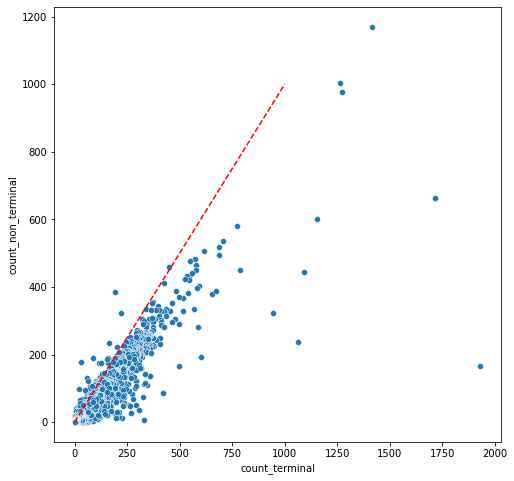

In [41]:
plt.figure(figsize=(8, 8))
sns.scatterplot(obs, x='count_terminal', y='count_non_terminal')
plt.plot([0, 1000],[0, 1000], 'r--')
print((obs.count_terminal / obs.count_non_terminal).replace(np.inf, np.nan).mean())

### Explore OBS

In [51]:
obs.codon_position.value_counts()

codon_position
1      110949
2      100113
1;1     89804
2;2     87542
3       29004
3;3     23236
Name: count, dtype: int64

In [52]:
obs_raw['count'].sum(), obs['count'].sum()

(np.int64(5635999), np.int64(3175359))

In [53]:
print('Number of mutations:')
obs_raw.groupby(['clade', 'synonymous'])['count'].sum().unstack()

Number of mutations:


synonymous,False,True
clade,,
19A,7462,3999
20A,67405,43933
20B,56079,36627
20C,56285,37562
20E,38269,24958
20F,2218,1300
20G,52212,36639
20I,217281,146099
20J,17075,12236


In [54]:
obs_raw.groupby(['clade', 'synonymous'])['count'].sum().unstack().shape

(30, 2)

In [55]:
print('Number of mutations:')
obs_raw.query('synonymous == True').groupby(['clade', 'four_fold_degenerate'])['count'].sum().unstack()

Number of mutations:


four_fold_degenerate,False,True
clade,,
19A,2299,1700
20A,24963,18970
20B,20543,16084
20C,21405,16157
20E,14092,10866
20F,758,542
20G,21294,15345
20I,84469,61630
20J,6871,5365


In [56]:
obs.groupby('clade')['count'].sum().rename('aa_subst_cnt').sort_index().reset_index()

,clade,aa_subst_cnt
0,19A,7185
1,20A,65078
2,20B,54164
3,20C,54346
4,20E,36904
5,20F,2161
6,20G,50463
7,20I,210313
8,20J,16464
9,21C,22742


### Check site specifity

In [57]:
ref_sites_df = read_genbank_ref('data/NC_045512.2.gb')
ref_sites_df = ref_sites_df[ref_sites_df.Codon.notna()]
# Pos and nt_site is the same
ref_sites_df

/home/kpotoh/env_bio/lib/python3.9/site-packages/Bio/SeqFeature.py:230: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(
/home/kpotoh/env_bio/lib/python3.9/site-packages/Bio/SeqFeature.py:230: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(


,Pos,Nuc,Context,Strand,Type,gene,PosInGene,PosInCodon,Codon
265,266,A,GAT,1,mat_peptide,ORF1ab,1,1,ATG
266,267,T,ATG,1,mat_peptide,ORF1ab,2,2,ATG
267,268,G,TGG,1,mat_peptide,ORF1ab,3,3,ATG
268,269,G,GGA,1,mat_peptide,ORF1ab,4,1,GAG
269,270,A,GAG,1,mat_peptide,ORF1ab,5,2,GAG
...,...,...,...,...,...,...,...,...,...
29669,29670,C,ACA,1,CDS,ORF10,113,2,ACA
29670,29671,A,CAT,1,CDS,ORF10,114,3,ACA
29671,29672,T,ATA,1,CDS,ORF10,115,1,TAG
29672,29673,A,TAG,1,CDS,ORF10,116,2,TAG


In [63]:
ref_sites_df['MutCount'] = ref_sites_df['Pos'].map(obs_raw.groupby('nt_site')['count'].sum()).fillna(0.)
ref_sites_df = ref_sites_df.merge(obs[['nt_site', 'codon_position']].drop_duplicates(), 
                   left_on='Pos', right_on='nt_site', how='left')
ref_sites_df

,Pos,Nuc,Context,Strand,Type,gene,PosInGene,PosInCodon,Codon,MutCount,nt_site_x,codon_position_x,nt_site_y,codon_position_y
0,266,A,GAT,1,mat_peptide,ORF1ab,1,1,ATG,0.0,NaN,NaN,NaN,NaN
1,267,T,ATG,1,mat_peptide,ORF1ab,2,2,ATG,2.0,267.0,2;2,267.0,2;2
2,268,G,TGG,1,mat_peptide,ORF1ab,3,3,ATG,1.0,268.0,3;3,268.0,3;3
3,269,G,GGA,1,mat_peptide,ORF1ab,4,1,GAG,239.0,269.0,1;1,269.0,1;1
4,270,A,GAG,1,mat_peptide,ORF1ab,5,2,GAG,154.0,270.0,2;2,270.0,2;2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29255,29670,C,ACA,1,CDS,ORF10,113,2,ACA,687.0,29670.0,2,29670.0,2
29256,29671,A,CAT,1,CDS,ORF10,114,3,ACA,114.0,29671.0,3,29671.0,3
29257,29672,T,ATA,1,CDS,ORF10,115,1,TAG,57.0,NaN,NaN,NaN,NaN
29258,29673,A,TAG,1,CDS,ORF10,116,2,TAG,29.0,NaN,NaN,NaN,NaN


In [64]:
ref_sites_df.MutCount.describe()

count    29260.000000
mean       191.781921
std        376.108149
min          0.000000
25%         27.000000
50%         78.000000
75%        176.000000
max       8529.000000
Name: MutCount, dtype: float64

In [65]:
ref_sites_df.MutCount.value_counts(normalize=True).rename('freq').reset_index()

,MutCount,freq
0,1.0,0.026760
1,0.0,0.024094
2,2.0,0.022078
3,3.0,0.018626
4,4.0,0.015379
...,...,...
1756,820.0,0.000034
1757,787.0,0.000034
1758,1351.0,0.000034
1759,1015.0,0.000034


In [75]:
ref_sites_df.MutCount.describe()

count    29260.000000
mean       191.781921
std        376.108149
min          0.000000
25%         27.000000
50%         78.000000
75%        176.000000
max       8529.000000
Name: MutCount, dtype: float64

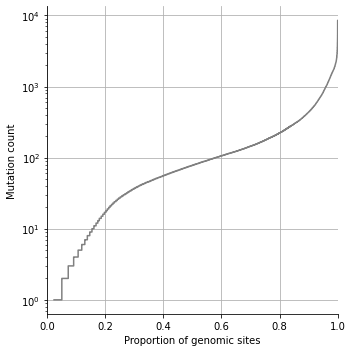

In [79]:
import matplotlib.patches as mpatches

sns.displot(ref_sites_df, y='MutCount', kind='ecdf', log_scale=(False, True), color='gray')
# plt.legend([
#         # mpatches.Patch(color='none'), 
#         mpatches.Patch(color='none'),
#     ],[
#         'maximal mutations per site is 6323'], 
#     loc='upper left')
plt.grid(True)
plt.ylabel('Mutation count')
plt.xlabel('Proportion of genomic sites')
plt.tight_layout()
# plt.savefig('./figures/mutational_count_per_site_ecdf.pdf', dpi=300)
plt.show()

### compare obs and exp in table

In [80]:
grantham = pd.read_csv('../grantham.tsv', sep='\t', index_col=0).replace(0, np.nan)
grantham.index.name = 'aa1'
grantham_long = grantham.melt(ignore_index=False, var_name='aa2', value_name='granthamD').dropna().reset_index()
grantham_long['aa1'] = grantham_long['aa1'].map(amino_acid_codes)
grantham_long['aa2'] = grantham_long['aa2'].map(amino_acid_codes)
grantham_long = pd.concat([grantham_long, grantham_long.rename(columns={'aa1':'aa2', 'aa2':'aa1'})], ignore_index=True)
grantham_long

,aa1,aa2,granthamD
0,Ser,Arg,110.0
1,Ser,Leu,145.0
2,Arg,Leu,102.0
3,Ser,Pro,74.0
4,Arg,Pro,103.0
...,...,...,...
375,Trp,Asn,174.0
376,Trp,Lys,110.0
377,Trp,Asp,181.0
378,Trp,Glu,152.0


In [169]:
obs_clade = obs[obs['clade'] == '20A']
aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
aa_subst['label'] = aa_subst.aa1 + '>' + aa_subst.aa2
aa_subst['mape'] = aa_subst['mape'].replace(-np.inf, 0)
aa_subst['diff_freqs_abs'] = (aa_subst['nobs_freqs'] - aa_subst['nexp_freqs']).abs()
aa_subst['division'] = (aa_subst['nobs_freqs'] / aa_subst['nexp_freqs'])
aa_subst['dist_to_diagonal'] = aa_subst['diff_freqs_abs'] / (2**0.5)
aa_subst = aa_subst.merge(grantham_long, 'left')
aa_subst.sort_values('mape')

,aa1,aa2,nobs,ref_aa1_freq,nobs_scaled,rate_exp,nexp,diff,mape,nobs_freqs,nexp_freqs,label,diff_freqs_abs,division,dist_to_diagonal,granthamD
57,Gly,Trp,11.0,0.059113,9.402410,1.114000,370.572256,-361.169846,-38.412475,0.000146,0.005751,Gly>Trp,0.005606,0.025373,0.003964,184.0
18,Arg,Trp,47.0,0.035920,66.114818,3.305960,1099.728057,-1033.613239,-15.633609,0.001026,0.017068,Arg>Trp,0.016042,0.060119,0.011344,101.0
15,Arg,Pro,9.0,0.035920,12.660284,0.386820,128.675727,-116.015443,-9.163731,0.000196,0.001997,Arg>Pro,0.001801,0.098389,0.001273,103.0
1,Ala,Glu,22.0,0.067529,16.461363,0.463480,154.176687,-137.715324,-8.365974,0.000255,0.002393,Ala>Glu,0.002137,0.106769,0.001511,107.0
143,Val,Asp,13.0,0.080152,8.195233,0.167334,55.663679,-47.468445,-5.792202,0.000127,0.000864,Val>Asp,0.000737,0.147228,0.000521,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,Asn,Thr,125.0,0.054598,115.682423,0.070100,23.318775,92.363648,0.798424,0.001795,0.000362,Asn>Thr,0.001434,4.960913,0.001014,65.0
97,Met,Val,254.0,0.021244,604.132732,0.346960,115.416293,488.716439,0.808955,0.009376,0.001791,Met>Val,0.007585,5.234380,0.005363,21.0
93,Met,Ile,1558.0,0.021244,3705.664553,2.042115,679.309841,3026.354712,0.816683,0.057514,0.010543,Met>Ile,0.046970,5.455043,0.033213,10.0
26,Asp,Ala,133.0,0.052443,128.144431,0.070100,23.318775,104.825656,0.818027,0.001989,0.000362,Asp>Ala,0.001627,5.495333,0.001150,126.0


Text(0.5, 0, 'PE')

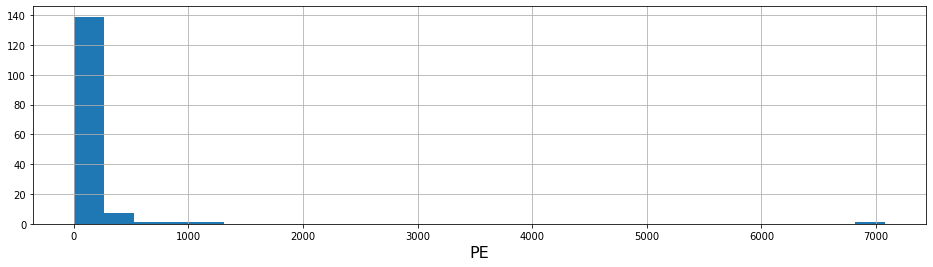

In [110]:
plt.figure(figsize=(16, 4))
(aa_subst.mape.abs()*100).hist(bins=27)
plt.xlabel('PE', fontsize=16)
# plt.xticks(range(0, 1500, 100));

In [111]:
aa_subst.query('label == "Gly>Trp"')

,aa1,aa2,nobs,ref_aa1_freq,nobs_scaled,rate_exp,nexp,diff,mape,nobs_freqs,nexp_freqs,label,diff_freqs_abs,division,dist_to_diagonal,granthamD
57,Gly,Trp,11.0,0.059113,9.40241,0.322075,675.33462,-665.93221,-70.825692,0.000146,0.010482,Gly>Trp,0.010336,0.013923,0.007308,184.0


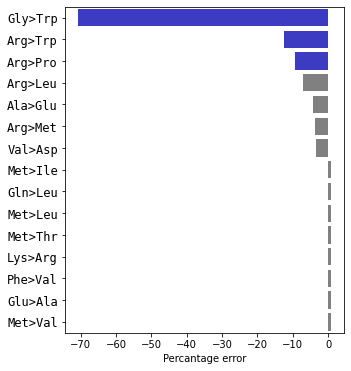

In [112]:
a = aa_subst['mape'][aa_subst['mape']>0].quantile(0.9)
b = aa_subst['mape'][aa_subst['mape']<0].quantile(0.1)

_d = aa_subst[(aa_subst['mape'] > a) | (aa_subst['mape'] < b)].copy()

plt.figure(figsize=(5, 6))
sns.barplot(aa_subst, y='label', x='mape', color='gray',
            order=_d.sort_values('mape').label)

# sns.barplot(aa_subst, y='label', x='mape', color='red', alpha=0.7,
#             order=_d.sort_values('mape').tail(3).label)
sns.barplot(aa_subst, y='label', x='mape', color='blue', alpha=0.7,
            order=_d.sort_values('mape').head(3).label)

plt.ylabel('')
# plt.xlim(-0.45, 0.45)
plt.xlabel('Percantage error')
plt.yticks(fontsize=12, fontname='monospace')
plt.show()

<Axes: >

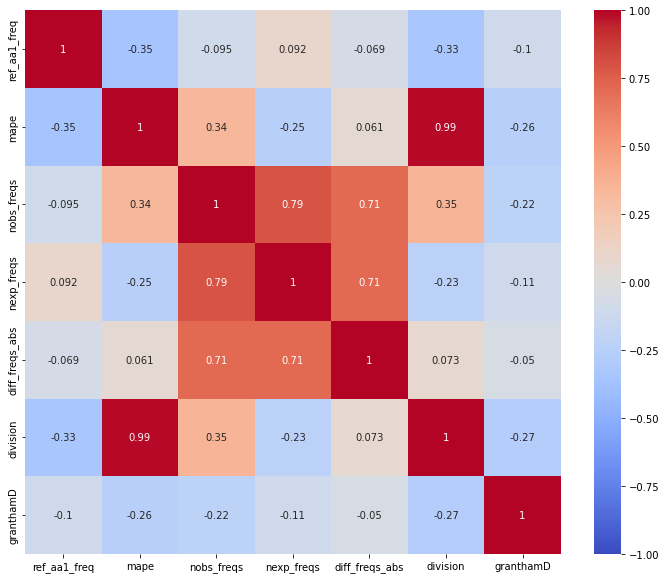

In [113]:
plt.figure(figsize=(12, 10))
sns.heatmap(aa_subst.drop(['aa1', 'aa2', 'label', 'nobs', 'nexp', 'nobs_scaled', 'dist_to_diagonal', 'diff', 'rate_exp'], axis=1).corr('spearman'), 
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)

Text(0, 0.5, 'Difference between OBS and PRED freqs')

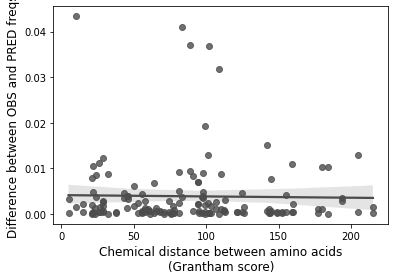

In [114]:
# plt.figure(figsize=(8, 8))
sns.regplot(aa_subst, x='granthamD', y='diff_freqs_abs', color='.3')
plt.xlabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)
plt.ylabel('Difference between OBS and PRED freqs', fontsize=12)
# plt.xscale('log')
# # plt.yscale('log')
# plt.text(2.5e-2, -3, '${MAPE=const}$', {'size': 16})
# plt.ylabel('MAPE')
# plt.xlabel('Observed frequency of amino acid substitution')

Text(0, 0.5, 'Expected frequencies')

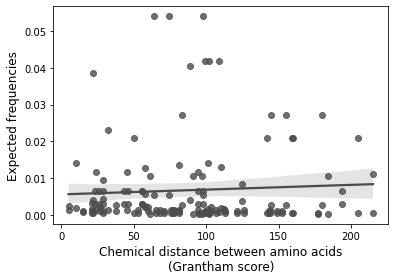

In [116]:
# plt.figure(figsize=(8, 8))
sns.regplot(aa_subst, x='granthamD', y='nexp_freqs', color='.3')
plt.xlabel('Chemical distance between amino acids\n(Grantham score)', fontsize=12)
plt.ylabel('Expected frequencies', fontsize=12)
# plt.xscale('log')
# # plt.yscale('log')
# plt.text(2.5e-2, -3, '${MAPE=const}$', {'size': 16})
# plt.ylabel('MAPE')
# plt.xlabel('Observed frequency of amino acid substitution')

Text(0.5, 0, 'Observed frequency of amino acid substitution')

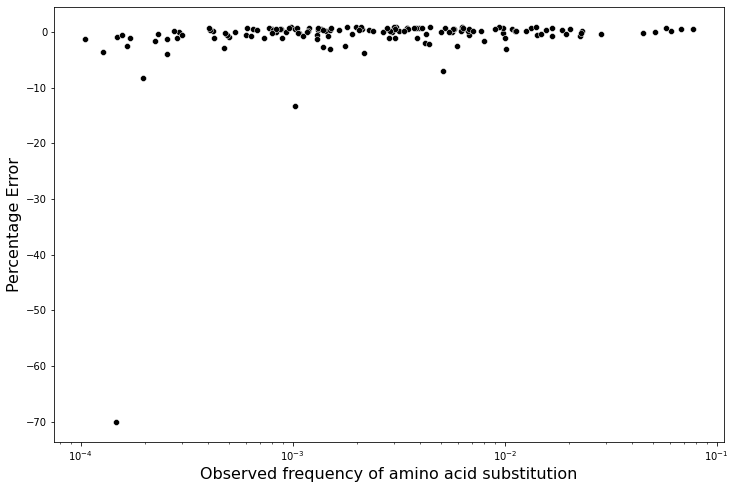

In [92]:
plt.figure(figsize=(12, 8))
sns.scatterplot(aa_subst, x='nobs_freqs', y='mape', c='k')
plt.xscale('log')
# plt.yscale('log')
# plt.text(2.5e-2, -3, '${MAPE=const}$', {'size': 16})
plt.ylabel('Percentage Error', fontsize=16)
plt.xlabel('Observed frequency of amino acid substitution', fontsize=16)

### Model definition and equilibrium

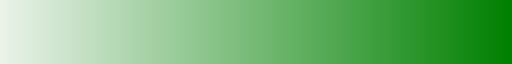

In [32]:
sns.color_palette("light:green", as_cmap=True)

In [117]:
def plot_exp_heatmap(exp_aa_subst_matrix: pd.DataFrame, save_path: str, show=True, annot=False):
    """
    Plot expected amino acid substitution matrix.
    """
    freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
    freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()
    max_flow_value = max(freqs_to.max(), freqs_from.max())+0.1

    fig, axs = plt.subplots(2, 3, figsize=(11, 10), 
                            width_ratios=[0.1, 1, .05], height_ratios=[1, 0.1])
    sns.heatmap(exp_aa_subst_matrix, annot=annot, fmt=".2f", 
                ax=axs[0, 1], cbar_ax=axs[0, 2], 
                cmap=sns.color_palette("light:green", as_cmap=True), 
                cbar_kws={'label': 'Substitution rate'}, vmin=0,
                mask=exp_aa_subst_matrix==0,
    )
    axs[0, 1].set_ylabel('')
    axs[0, 1].set_xlabel('')
    axs[0, 1].set_xticks([])
    axs[0, 1].set_yticks([])
    # axs[0, 1].set_title('Expected substitution rates between amino acids')

    sns.barplot(freqs_from.reset_index(), y='aa1', x=0, ax=axs[0, 0],
                color='lightgray', edgecolor='black')
    axs[0, 0].set_ylabel('Original', fontsize=14)
    axs[0, 0].set_xlabel('Total Loss')
    axs[0, 0].spines['top'].set_visible(False)
    axs[0, 0].spines['right'].set_visible(False)
    axs[0, 0].spines['bottom'].set_visible(False)
    axs[0, 0].spines['left'].set_visible(False)
    axs[0, 0].invert_xaxis()
    axs[1, 1].set_ylim(0, max_flow_value)
    axs[0, 0].set_xticks([])
    axs[0, 0].set_yticklabels(axs[0, 0].get_yticklabels(), fontsize=12)

    sns.barplot(freqs_to.reset_index(), x='aa2', y=0, ax=axs[1, 1],
                color='lightgray', edgecolor='black')
    axs[1, 1].set_ylabel('Total Gain')
    axs[1, 1].set_xlabel('Mutant', fontsize=14)
    axs[1, 1].spines['top'].set_visible(False)
    axs[1, 1].spines['right'].set_visible(False)
    axs[1, 1].spines['bottom'].set_visible(False)
    axs[1, 1].spines['left'].set_visible(False)
    axs[1, 1].invert_yaxis()
    axs[1, 1].set_ylim(max_flow_value, 0)
    axs[1, 1].set_yticks([])
    axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), fontsize=12)

    axs[1, 0].remove()
    axs[1, 2].remove()

    plt.tight_layout()
    plt.savefig(save_path)
    if show:
        plt.show()
    else:
        plt.close(fig)

/tmp/ipykernel_48045/665892802.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0, 0].set_yticklabels(axs[0, 0].get_yticklabels(), fontsize=12)
/tmp/ipykernel_48045/665892802.py:47: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1, 1].set_xticklabels(axs[1, 1].get_xticklabels(), fontsize=12)


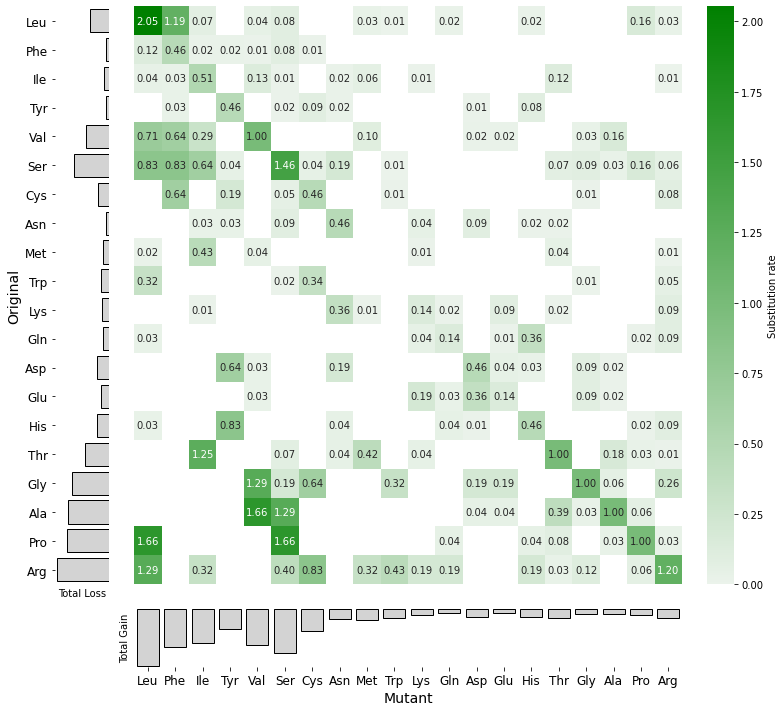

In [118]:
_, exp_aa_subst_matrix = prepare_exp_aa_subst(spectrum_20A, gc=1)

freqs_from = (exp_aa_subst_matrix.sum(1) - exp_aa_subst_matrix.values.diagonal()).copy()
freqs_to = (exp_aa_subst_matrix.sum(0) - exp_aa_subst_matrix.values.diagonal()).copy()

_freqs_to = (freqs_to / freqs_to.sum()).copy()
_freqs_from = (freqs_from / freqs_from.sum()).copy()
_freqs_to.index.name = 'aa'
_freqs_from.index.name = 'aa'

flow = (_freqs_to - _freqs_from).sort_values(ascending=False).rename('Flow').reset_index()

plot_exp_heatmap(exp_aa_subst_matrix.loc[flow.aa, flow.aa], 
                 'figures/exp_exp_aa_subst_matrix_20A.pdf', show=True, annot=True)

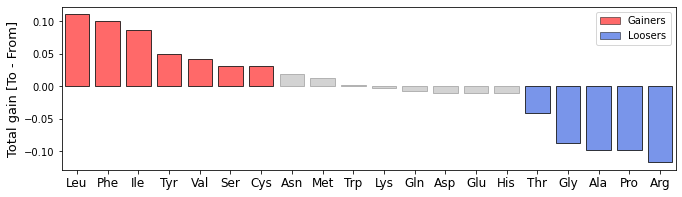

In [119]:
plt.figure(figsize=(11, 3))
ax = sns.barplot(
    flow, x='aa', y='Flow', color='lightgray', edgecolor=".65", linewidth=0.8)

cutoff = flow.Flow.abs().max() * 0.25

for bar in ax.patches:
    if bar.get_height() > cutoff:
        bar.set_color("#ff6969")
        bar.set_edgecolor('0.05')
    elif bar.get_height() < -cutoff:
        bar.set_color('#7995ea')
        bar.set_edgecolor('0.05')
        bar.set_linewidth


plt.legend([
    plt.Rectangle((0,0),1,1,fc="#ff6969", edgecolor='.05',linewidth=0.5), 
    plt.Rectangle((0,0),1,1,fc='#7995ea', edgecolor='.05',linewidth=0.5),
    ],['Gainers', 'Loosers',], loc='upper right')

# plt.title(f"{virusname}; G: {losers_gainers[i]['gainers']}; L: {losers_gainers[i]['losers']}")
plt.ylabel('Total gain [To - From]', fontsize=13)
plt.xlabel('')
plt.xticks(fontsize=12)
plt.show()

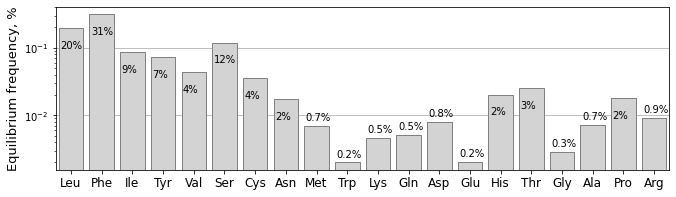

In [120]:
cur_eq_freqs_aa = pd.read_csv('./data/20A/aa_eq_freqs.csv')

plt.figure(figsize=(11, 3))
ax=sns.barplot(cur_eq_freqs_aa, x='aa', y='freq', order=flow.aa, color='lightgray', edgecolor='gray')

for i, aa in enumerate(flow.aa.values):
    f = cur_eq_freqs_aa.query('aa == @aa').freq.item()
    x = i-0.35
    if f < 0.016:
        lbl = f"{f*100:.1f}%" 
        y = f * 1.2
    else:
        lbl = f"{f*100:.0f}%"
        y = f * 0.5
    ax.text(x, y, lbl)

plt.ylabel('Equilibrium frequency, %', fontsize=13)
plt.xticks(fontsize=12)
# plt.ylim(0, 1)
plt.xlabel('')
plt.yscale('log', base=10)
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

In [121]:
flow.head(7).aa

0    Leu
1    Phe
2    Ile
3    Tyr
4    Val
5    Ser
6    Cys
Name: aa, dtype: object

In [122]:
cur_eq_freqs_aa[cur_eq_freqs_aa.aa.isin(flow.head(7).aa)].freq.sum().round(2)

np.float64(0.87)

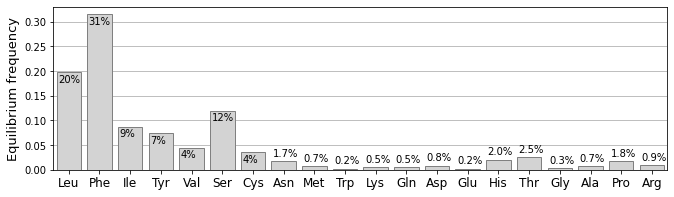

In [123]:
plt.figure(figsize=(11, 3))
ax=sns.barplot(cur_eq_freqs_aa, x='aa', y='freq', order=flow.aa, color='lightgray', edgecolor='gray')

for i, aa in enumerate(flow.aa.values):
    f = cur_eq_freqs_aa.query('aa == @aa').freq.item()
    x = i-0.35
    if f < 0.03:
        lbl = f"{f*100:.1f}%" 
        y = f + 0.01
    else:
        lbl = f"{f*100:.0f}%"
        y = f - 0.02
    ax.text(x, y, lbl)

plt.ylabel('Equilibrium frequency', fontsize=13)
plt.xticks(fontsize=12)
plt.xlabel('')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.show()

In [124]:
aa_subst

,aa1,aa2,nobs,ref_aa1_freq,nobs_scaled,rate_exp,nexp,diff,mape,nobs_freqs,nexp_freqs,label,diff_freqs_abs,division,dist_to_diagonal,granthamD
0,Ala,Asp,124.0,0.067529,92.782226,0.040682,85.303028,7.479198,0.080610,0.001440,0.001324,Ala>Asp,0.000116,1.087678,0.000082,126.0
1,Ala,Glu,22.0,0.067529,16.461363,0.040682,85.303028,-68.841665,-4.182015,0.000255,0.001324,Ala>Glu,0.001068,0.192975,0.000756,107.0
2,Ala,Gly,25.0,0.067529,18.706094,0.028605,59.979759,-41.273665,-2.206429,0.000290,0.000931,Ala>Gly,0.000641,0.311873,0.000453,60.0
3,Ala,Pro,41.0,0.067529,30.677994,0.062066,130.141215,-99.463221,-3.242168,0.000476,0.002020,Ala>Pro,0.001544,0.235729,0.001092,27.0
4,Ala,Ser,1953.0,0.067529,1461.320057,1.288299,2701.338481,-1240.018424,-0.848560,0.022680,0.041926,Ala>Ser,0.019246,0.540961,0.013609,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,Val,Gly,82.0,0.080152,51.693009,0.026069,54.661133,-2.968123,-0.057418,0.000802,0.000848,Val>Gly,0.000046,0.945700,0.000033,109.0
146,Val,Ile,1153.0,0.080152,726.854141,0.291929,612.123254,114.730886,0.157846,0.011281,0.009500,Val>Ile,0.001781,1.187431,0.001259,29.0
147,Val,Leu,1451.0,0.080152,914.714101,0.706215,1480.810456,-566.096355,-0.618878,0.014197,0.022983,Val>Leu,0.008786,0.617712,0.006213,32.0
148,Val,Met,133.0,0.080152,83.843539,0.097310,204.041085,-120.197546,-1.433593,0.001301,0.003167,Val>Met,0.001866,0.410915,0.001319,21.0


### subst freqs plot

In [150]:
def plot_subst_freqs(aa_subst, title=''):
    aa_subst = aa_subst.copy()
    aa_subst['nobs_freqs_log'] = np.log10(aa_subst['nobs_freqs'])
    aa_subst['nexp_freqs_log'] = np.log10(aa_subst['nexp_freqs'])

    y_true, y_pred = aa_subst['nobs_freqs'], aa_subst['nexp_freqs']
    cor_res = spearmanr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"Spearman correlation: {cor_res.correlation:.3f} (p-value: {cor_res.pvalue:.3g})")

    plt.figure(figsize=(8, 8))
    ax = sns.regplot(aa_subst[aa_subst['nobs_freqs']>0], 
                color='blue', scatter_kws={'alpha':0.5, 's':50},
                y='nobs_freqs_log', x='nexp_freqs_log')

    ticks = np.linspace(-4, -1, 4)
    ticks_minor = np.log10(np.concat([
        np.linspace(10**-4, 10**-3, 10),
        np.linspace(10**-3, 10**-2, 10)[1:],
        np.linspace(10**-2, 10**-1, 10)[1:],
    ]))
    ax.set_xticks(ticks, ticks, size=14)
    ax.set_yticks(ticks, ticks, size=14)
    ax.set_xticks(ticks_minor, minor=True)
    ax.set_yticks(ticks_minor, minor=True)
    formatter = lambda x, pos: '10$^{' + str(int(x)) + '}$'
    ax.get_xaxis().set_major_formatter(formatter)
    ax.get_yaxis().set_major_formatter(formatter)
    # ax.get_xaxis().set_minor_locator(LogLocator(-10, 'auto'))
    # ax.get_xaxis().set_minor_locator(LogLocator())

    # plt.text(-2, -4., 
    #          f"r={cor_res.correlation:.1f} (p={cor_res.pvalue:.1g})", 
    #          fontsize=10)
    plt.plot([-4, -1], [-4, -1], color='black', linestyle='--',)
    plt.ylabel('Observed AA substitution frequencies', fontsize=14)
    plt.xlabel('Predicted AA substitution frequencies', fontsize=14)
    # plt.ylabel('Наблюдаемые частоты замещений аминокислот', fontsize=14)
    # plt.xlabel('Ожидаемые частоты замещений аминокислот', fontsize=14)
    plt.title(title, fontsize=16)
    # plt.legend(title=f"spearmanr={cor_res.correlation:.2f} (p={cor_res.pvalue:.1g})", title_fontsize=14)
    plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=14)
    # plt.savefig('./figures/obs_exp_aa_freqs_20A.pdf')
    plt.show()

/home/kpotoh/env_bio/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_11623/3755427975.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=14)


Spearman correlation: 0.772 (p-value: 6.49e-31)


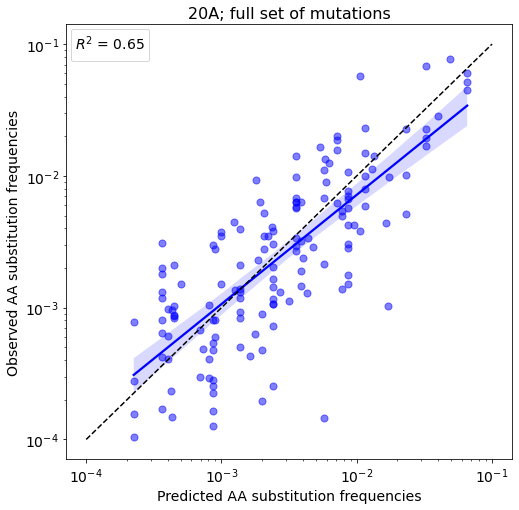

In [151]:
obs_clade = obs[obs['clade'] == '20A']
aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(aa_subst, '20A; full set of mutations', )

In [152]:
calc_metrics(aa_subst)

{'r2': 0.646469442450282,
 'mape': 1.344244366859443,
 'wape': 0.5652226761732914,
 'slope': np.float64(0.7602151547719024),
 'intercept': np.float64(0.0015985656348539805),
 'spearman_corr': np.float64(0.7719010523515886),
 'spearman_p': np.float64(6.489552271794182e-31),
 'pearson_corr': np.float64(0.8131871915960572),
 'pearson_p': np.float64(1.2979616672596386e-36),
 'ks_stat': np.float64(0.08),
 'ks_p': np.float64(0.7249566931207618),
 'rmse': 0.007360286652640094,
 'log_likelihood': np.float64(-5.339261292271988),
 'mut_count': np.float64(64430.99999999999)}

Spearman correlation: 0.792 (p-value: 1.5e-33)


/home/kpotoh/env_bio/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_48045/3755427975.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=14)


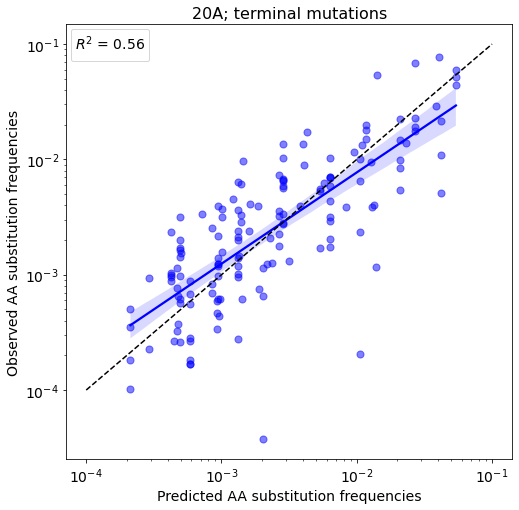

In [178]:
obs_clade = obs[obs['clade'] == '20A'].rename(columns={'count': 'count_all', 'count_terminal': 'count'})
aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(aa_subst, '20A; terminal mutations', )

/home/kpotoh/env_bio/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_48045/3755427975.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=14)


Spearman correlation: 0.779 (p-value: 7.2e-32)


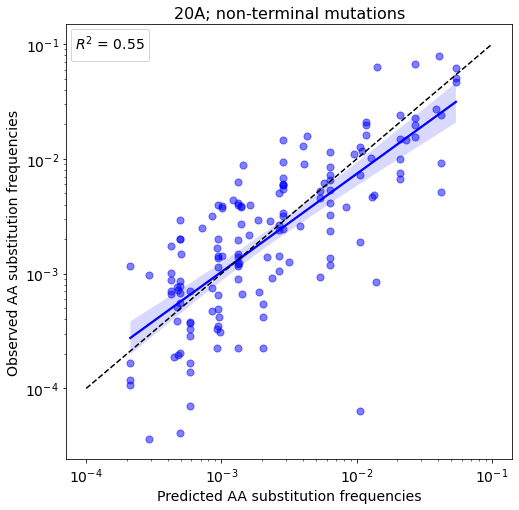

In [179]:
obs_clade = obs[obs['clade'] == '20A'].rename(columns={'count': 'count_all', 'count_non_terminal': 'count'})
aa_subst = prepare_aa_subst(obs_clade, exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(aa_subst, '20A; non-terminal mutations', )

/home/kpotoh/env_bio/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


pos=1: $R^2$ = 0.65
pos=2: $R^2$ = 0.65
pos=3: $R^2$ = 0.46


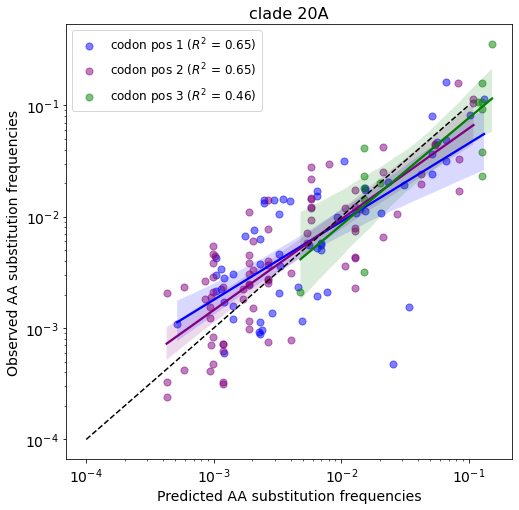

In [127]:
title = 'clade 20A'

_exp_aa_subst1 = df_changes[
    (df_changes.aa1 != '*') & 
    (df_changes.aa2 != '*') &
    (df_changes.pic == 0)
].groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
_exp_aa_subst2 = df_changes[
    (df_changes.aa1 != '*') & 
    (df_changes.aa2 != '*') &
    (df_changes.pic == 1)
].groupby(['aa1', 'aa2'])['rate'].sum().reset_index()
_exp_aa_subst3 = df_changes[
    (df_changes.aa1 != '*') & 
    (df_changes.aa2 != '*') &
    (df_changes.pic == 2)
].groupby(['aa1', 'aa2'])['rate'].sum().reset_index()


_aa_subst1 = prepare_aa_subst(obs_clade.query(f'codon_position == "1"'), _exp_aa_subst1, aa_freqs_total_dct)
_aa_subst2 = prepare_aa_subst(obs_clade.query(f'codon_position == "2"'), _exp_aa_subst2, aa_freqs_total_dct)
_aa_subst3 = prepare_aa_subst(obs_clade.query(f'codon_position == "3"'), _exp_aa_subst3, aa_freqs_total_dct)


_aa_subst1['nobs_freqs_log'] = np.log10(_aa_subst1['nobs_freqs'])
_aa_subst1['nexp_freqs_log'] = np.log10(_aa_subst1['nexp_freqs'])
_aa_subst2['nobs_freqs_log'] = np.log10(_aa_subst2['nobs_freqs'])
_aa_subst2['nexp_freqs_log'] = np.log10(_aa_subst2['nexp_freqs'])
_aa_subst3['nobs_freqs_log'] = np.log10(_aa_subst3['nobs_freqs'])
_aa_subst3['nexp_freqs_log'] = np.log10(_aa_subst3['nexp_freqs'])

r2_1 = r2_score(_aa_subst1['nobs_freqs'], _aa_subst1['nexp_freqs'])
r2_2 = r2_score(_aa_subst2['nobs_freqs'], _aa_subst2['nexp_freqs'])
r2_3 = r2_score(_aa_subst3['nobs_freqs'], _aa_subst3['nexp_freqs'])
print(f"pos=1: $R^2$ = {r2_1:.2f}")
print(f"pos=2: $R^2$ = {r2_2:.2f}")
print(f"pos=3: $R^2$ = {r2_3:.2f}")

plt.figure(figsize=(8, 8))
sns.regplot(_aa_subst1[_aa_subst1['nobs_freqs']>0], 
            color='blue', scatter_kws={'alpha':0.5, 's':50},
            y='nobs_freqs_log', x='nexp_freqs_log', label=f'codon pos 1 ($R^2$ = {r2_1:.2f})')

sns.regplot(_aa_subst2[_aa_subst2['nobs_freqs']>0], 
            color='purple', scatter_kws={'alpha':0.5, 's':50},
            y='nobs_freqs_log', x='nexp_freqs_log', label=f'codon pos 2 ($R^2$ = {r2_2:.2f})')


ax = sns.regplot(_aa_subst3[_aa_subst3['nobs_freqs']>0], 
            color='green', scatter_kws={'alpha':0.5, 's':50},
            y='nobs_freqs_log', x='nexp_freqs_log', label=f'codon pos 3 ($R^2$ = {r2_3:.2f})')

ticks = np.linspace(-4, -1, 4)
ticks_minor = np.log10(np.concat([
    np.linspace(10**-4, 10**-3, 10),
    np.linspace(10**-3, 10**-2, 10)[1:],
    np.linspace(10**-2, 10**-1, 10)[1:],
]))
ax.set_xticks(ticks, ticks, size=14)
ax.set_yticks(ticks, ticks, size=14)
ax.set_xticks(ticks_minor, minor=True)
ax.set_yticks(ticks_minor, minor=True)
formatter = lambda x, pos: '10$^{' + str(int(x)) + '}$'
ax.get_xaxis().set_major_formatter(formatter)
ax.get_yaxis().set_major_formatter(formatter)
# ax.get_xaxis().set_minor_locator(LogLocator(-10, 'auto'))
# ax.get_xaxis().set_minor_locator(LogLocator())

# plt.text(-2, -4., 
#          f"r={r2_.correlation:.1f} (p={r2_.pvalue:.1g})", 
#          fontsize=10)
plt.plot([-4, -1], [-4, -1], color='black', linestyle='--',)
plt.ylabel('Observed AA substitution frequencies', fontsize=14)
plt.xlabel('Predicted AA substitution frequencies', fontsize=14)
plt.title(title, fontsize=16)
plt.legend(fontsize=12)
# plt.legend(title=f"spearmanr={r2_.correlation:.2f} (p={r2_.pvalue:.1g})", title_fontsize=14)
plt.savefig('./figures/obs_exp_aa_freqs_20A.pdf')
plt.show()

/home/kpotoh/env_bio/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_48045/3755427975.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=14)


Spearman correlation: 0.691 (p-value: 1.3e-22)


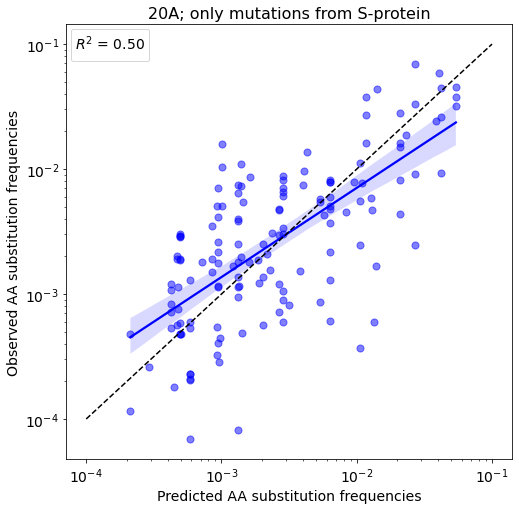

In [128]:
_aa_subst = prepare_aa_subst(obs_clade[obs_clade.protein == 'S'], exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(_aa_subst, '20A; only mutations from S-protein', )

/home/kpotoh/env_bio/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_48045/3755427975.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=14)


Spearman correlation: 0.775 (p-value: 2.98e-31)


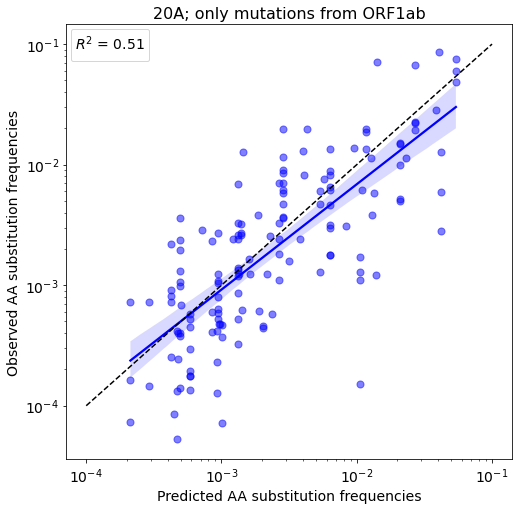

In [129]:
# _aa_subst = prepare_aa_subst(obs_clade[obs_clade.protein == 'ORF1ab'], exp_aa_subst, aa_freqs_total_dct)
_aa_subst = prepare_aa_subst(obs_clade[obs_clade.protein.str.contains('ORF1ab')], exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(_aa_subst, '20A; only mutations from ORF1ab', )

### separate on genes

In [ ]:
metrics_data = []
for (cur_clade, cur_protein), cur_obs in obs.groupby(['clade', 'protein']):
    if cur_clade not in clades_spectra['clade'].values:
        continue
    spectrum_clade = clades_spectra[clades_spectra['clade'] == cur_clade]
    cur_exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    
    cur_obs = cur_obs[(cur_obs.aa1 != '*') & (cur_obs.aa2 != '*')]
    aa_subst = prepare_aa_subst(cur_obs, cur_exp_aa_subst, aa_freqs_total_dct)

    aa_subst = aa_subst.dropna()
    y_true = aa_subst.nobs_scaled
    y_pred = aa_subst.nexp
    
    mask = y_true > 0
    wape = weighted_average_percentage_error(y_true[mask], y_pred[mask])
    spearman_corr, spearman_p = spearmanr(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    metrics_data.append({
        'clade': cur_clade,
        'protein': cur_protein,
        'wape': wape,
        'r2': r2,
        'spearmanr': spearman_corr,
        'spearmanp': spearman_p,
    })

metrics_data = pd.DataFrame(metrics_data)
metrics_data

,clade,protein,wape,r2,spearmanr,spearmanp
0,20A,E,0.822073,0.352147,0.518885,1.029739e-11
1,20A,M,0.825493,0.166837,0.663380,2.251096e-20
2,20A,N,0.677942,0.477526,0.599580,5.197480e-16
3,20A,ORF10,0.589456,0.371209,0.394511,5.869526e-07
4,20A,ORF1a;ORF1ab,0.701353,0.485702,0.751091,1.778224e-28
...,...,...,...,...,...,...
283,24A,ORF6,0.774131,-0.281383,0.206283,1.132190e-02
284,24A,ORF7a,0.706114,0.465111,0.586876,2.966801e-15
285,24A,ORF7b,0.743327,0.096589,0.180399,2.716782e-02
286,24A,ORF8,0.612913,0.563145,0.606865,1.848094e-16


In [68]:
metrics_data[metrics_data.spearmanp > 0.05]

,clade,protein,wape,r2,spearmanr,spearmanp
117,21J,ORF7b,0.874846,0.032477,0.077860,0.343616
129,21K,ORF7b,0.806045,0.109016,0.137337,0.093756
141,21L,ORF7b,0.770867,0.065367,0.081095,0.323879
165,22B,ORF7b,0.880968,0.044888,0.135532,0.098193


In [69]:
obs.groupby(['protein', 'clade'])['count'].sum()#.sort_values()

protein  clade
E        19A         62
         20A        544
         20B        482
         20C        469
         20E        361
                  ...  
S        23F       7648
         24A      11675
         24B       1753
         24C       1554
         24E       2449
Name: count, Length: 360, dtype: int64

In [70]:
metrics_data_sized = metrics_data.merge(
    obs.groupby(['protein', 'clade'])['count'].sum().rename('nmut').reset_index())
metrics_data_sized

,clade,protein,wape,r2,spearmanr,spearmanp,nmut
0,20A,E,0.822073,0.352147,0.518885,1.029739e-11,544
1,20A,M,0.825493,0.166837,0.663380,2.251096e-20,1080
2,20A,N,0.677942,0.477526,0.599580,5.197480e-16,4357
3,20A,ORF10,0.589456,0.371209,0.394511,5.869526e-07,514
4,20A,ORF1a;ORF1ab,0.701353,0.485702,0.751091,1.778224e-28,26516
...,...,...,...,...,...,...,...
283,24A,ORF6,0.774131,-0.281383,0.206283,1.132190e-02,424
284,24A,ORF7a,0.706114,0.465111,0.586876,2.966801e-15,2021
285,24A,ORF7b,0.743327,0.096589,0.180399,2.716782e-02,410
286,24A,ORF8,0.612913,0.563145,0.606865,1.848094e-16,1998


In [71]:
metrics_data_sized.set_index(['clade', 'protein']).corr('spearman')

,wape,r2,spearmanr,spearmanp,nmut
wape,1.000000,-0.821520,-0.542246,0.542246,-0.380314
r2,-0.821520,1.000000,0.653273,-0.653273,0.592400
spearmanr,-0.542246,0.653273,1.000000,-1.000000,0.756325
spearmanp,0.542246,-0.653273,-1.000000,1.000000,-0.756325
nmut,-0.380314,0.592400,0.756325,-0.756325,1.000000


In [75]:
metrics_data_sized

,clade,protein,wape,r2,spearmanr,spearmanp,nmut
0,20A,E,0.822073,0.352147,0.518885,1.029739e-11,544
1,20A,M,0.825493,0.166837,0.663380,2.251096e-20,1080
2,20A,N,0.677942,0.477526,0.599580,5.197480e-16,4357
3,20A,ORF10,0.589456,0.371209,0.394511,5.869526e-07,514
4,20A,ORF1a;ORF1ab,0.701353,0.485702,0.751091,1.778224e-28,26516
...,...,...,...,...,...,...,...
283,24A,ORF6,0.774131,-0.281383,0.206283,1.132190e-02,424
284,24A,ORF7a,0.706114,0.465111,0.586876,2.966801e-15,2021
285,24A,ORF7b,0.743327,0.096589,0.180399,2.716782e-02,410
286,24A,ORF8,0.612913,0.563145,0.606865,1.848094e-16,1998


Text(0.5, 20.80000000000001, 'Mutations count in clade')

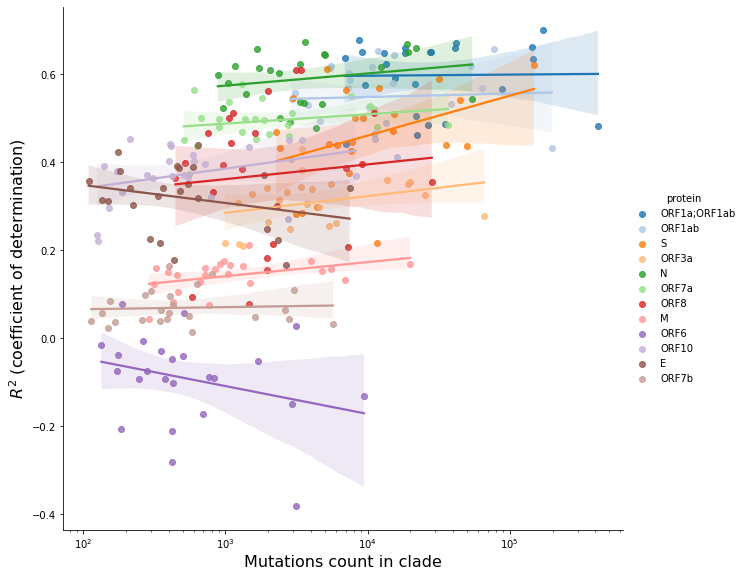

In [93]:
sns.lmplot(metrics_data_sized, y='r2', x='nmut', hue='protein', 
           hue_order=metrics_data_sized.groupby('protein')['nmut'].mean().sort_values(ascending=False).index,
           height=8, aspect=1.1, logx=True, palette='tab20')
plt.xscale('log')
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=16)
plt.xlabel('Mutations count in clade', fontsize=16)

Text(0.5, 0, 'Gene')

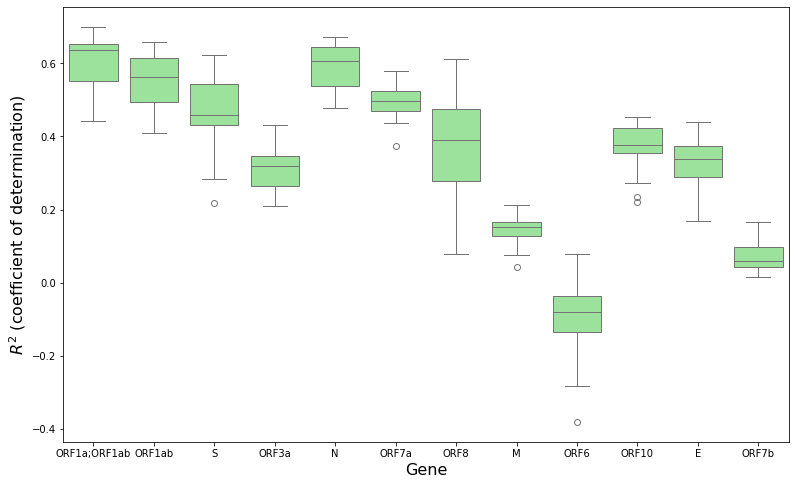

In [90]:
plt.figure(figsize=(13, 8))
sns.boxplot(metrics_data, x='protein', y='r2', color='lightgreen',
            # order=['ORF1a;ORF1ab', 'ORF1ab', 'S', 'ORF3a', 'M', 'N'],
            order=metrics_data_sized.groupby('protein')['nmut'].mean().sort_values(ascending=False).index,
)
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=16)
plt.xlabel('Gene', fontsize=16)

### How many mutations required for unbiased resilt?

In [ ]:
sdata_full = []
for (cur_clade, ), obs_clade in obs.groupby(['clade']):
    if cur_clade not in clades_spectra['clade'].values:
        continue
    spectrum_clade = clades_spectra[clades_spectra['clade'] == cur_clade]
    cur_exp_aa_subst, _ = prepare_exp_aa_subst(spectrum_clade, 'rate', 1)
    
    obs_clade = obs_clade[(obs_clade.aa1 != '*') & (obs_clade.aa2 != '*')]

    exploded = []
    for _, x in obs_clade[['aa1', 'aa2', 'count']].iterrows():
        for _ in range(x['count']):
            exploded.append(x)
    exploded = pd.DataFrame(exploded).reset_index(drop=True)
    exploded['count'] = 1

    sdata = []
    for n in np.logspace(2, np.log10(len(exploded)-10), 100).astype(int):
        cur_sample = exploded.sample(n, replace=False)
        _aa_subst = prepare_aa_subst(cur_sample, cur_exp_aa_subst, aa_freqs_total_dct)
        cor_res = spearmanr(_aa_subst['nobs_freqs'], _aa_subst['nexp_freqs'])
        r2 = r2_score(_aa_subst['nobs_freqs'], _aa_subst['nexp_freqs'])
        sdata.append([n, cor_res.correlation, r2])

    sdata = pd.DataFrame(sdata, columns=['n', 'cor', 'r2']).assign(clade=cur_clade)
    sdata_full.append(sdata)


sdata_full_df = pd.concat(sdata_full)
sdata_full_df

,n,cor,r2,clade
0,100,0.472110,0.330910,20A
1,106,0.536463,0.389653,20A
2,113,0.481192,0.276265,20A
3,121,0.543176,0.485366,20A
4,129,0.473410,0.128456,20A
...,...,...,...,...
95,43245,0.786559,0.674945,22C
96,46098,0.792050,0.677014,22C
97,49140,0.789173,0.672573,22C
98,52382,0.792079,0.672765,22C


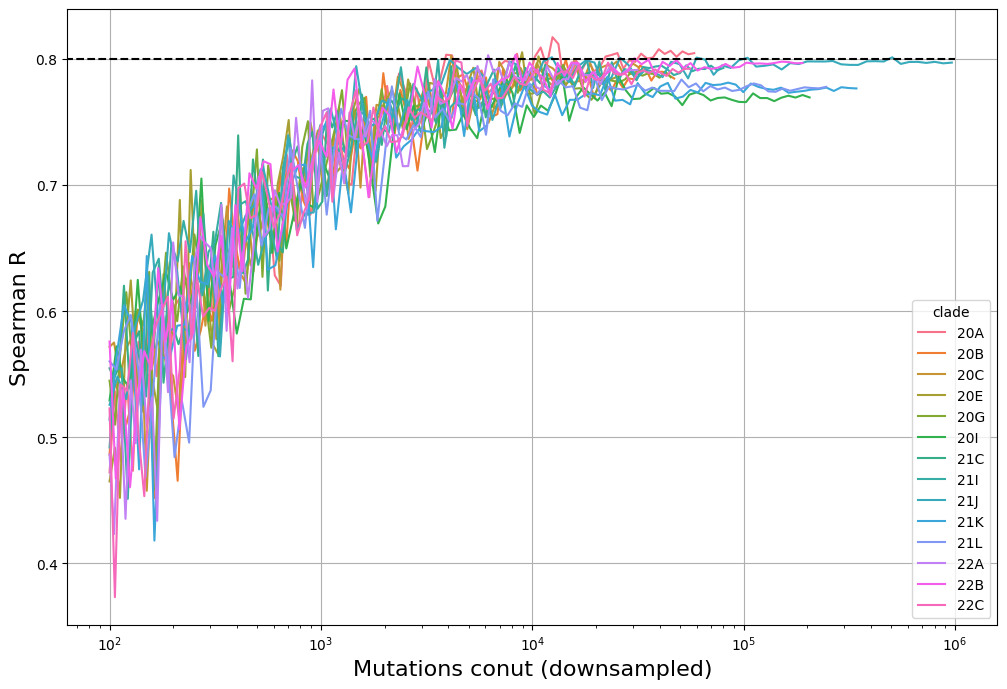

In [96]:
plt.figure(figsize=(12, 8))
sns.lineplot(sdata_full_df, x='n', y='cor', hue='clade')
plt.hlines(0.8, 0, 10**6, 'k', '--')
plt.grid()
plt.ylabel('Spearman R', fontsize=16)
plt.xlabel('Mutations conut (downsampled)', fontsize=16)
plt.xscale('log')

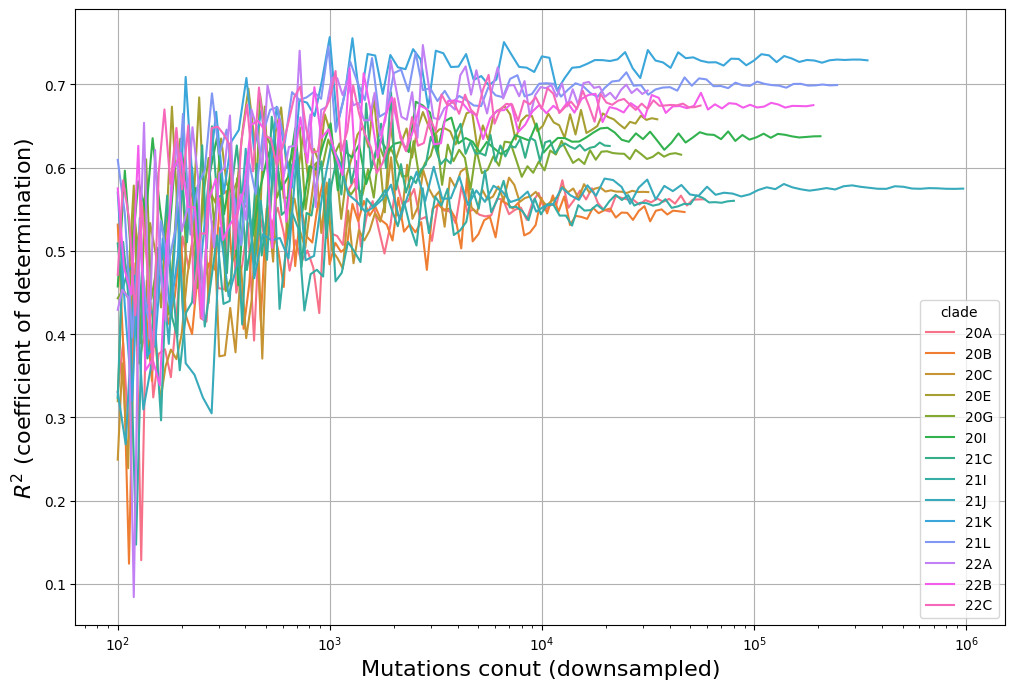

In [95]:
plt.figure(figsize=(12, 8))
sns.lineplot(sdata_full_df, x='n', y='r2', hue='clade')
# plt.hlines(0.63, 0, 10**6, 'k', '--')
plt.grid()
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=16)
plt.xlabel('Mutations conut (downsampled)', fontsize=16)
plt.xscale('log')

## Fitness

In [10]:
aamut_fitness = pd.read_csv('./data/bloom_etal/aamut_fitness_by_clade.csv')
aamut_fitness['aa1'] = aamut_fitness['aa_mutation'].str[0]
aamut_fitness['aa2'] = aamut_fitness['aa_mutation'].str[-1]
aamut_fitness

,clade,gene,clade_founder_aa,mutant_aa,aa_site,aa_mutation,expected_count,actual_count,count_terminal,count_non_terminal,mean_log_size,subset_of_ORF1ab,delta_fitness,aa1,aa2
0,20A,E,A,A,22,A22A,1.87400,2,0,2,2.41010,False,0.051727,A,A
1,20A,E,A,A,32,A32A,14.74200,20,14,6,0.41743,False,0.296350,A,A
2,20A,E,A,A,36,A36A,14.48000,1,0,1,1.94590,False,-2.301200,A,A
3,20A,E,A,A,41,A41A,14.48000,3,2,1,0.82833,False,-1.453900,A,A
4,20A,E,A,D,22,A22D,0.67725,0,0,0,0.00000,False,-0.856330,A,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2893365,24A,nsp1,Y,F,97,Y97F,0.77908,0,0,0,0.00000,True,-0.939290,Y,F
2893366,24A,nsp1,Y,H,97,Y97H,2.17910,0,0,0,0.00000,True,-1.678600,Y,H
2893367,24A,nsp1,Y,N,97,Y97N,0.48805,0,0,0,0.00000,True,-0.681130,Y,N
2893368,24A,nsp1,Y,S,97,Y97S,0.20445,0,0,0,0.00000,True,-0.342810,Y,S


In [11]:
aamut_fitness_ns = aamut_fitness.query('aa1 != aa2 & aa1 != "*" & aa2 != "*"')

In [177]:
aamut_fitness_ns.query('clade == "20A" & actual_count > 0 & delta_fitness < -0.5').actual_count.sum()

np.int64(17931)

In [178]:
aamut_fitness_ns.query('clade == "20A" & actual_count > 0 & delta_fitness < -3').actual_count.sum()

np.int64(0)

In [16]:
_ = obs.query('clade == "20A"')
calc_metrics(prepare_aa_subst(_, exp_aa_subst, aa_freqs_total_dct))

{'r2': 0.5541920419627184,
 'mape': 1.4038124517823016,
 'wape': 0.5818972518588895,
 'slope': np.float64(0.6906928257488198),
 'intercept': np.float64(0.0020620478283411995),
 'spearman_corr': np.float64(0.7899707851528157),
 'spearman_p': np.float64(2.9925092584177307e-33),
 'pearson_corr': np.float64(0.7594188270144773),
 'pearson_p': np.float64(2.0145536289396837e-29),
 'ks_stat': np.float64(0.12),
 'ks_p': np.float64(0.23078236357216822),
 'rmse': 0.008265234083120913,
 'log_likelihood': np.float64(-5.368781765558867),
 'mut_count': np.float64(64430.99999999999)}

In [17]:
_ = aamut_fitness_ns.query('clade == "20A" & delta_fitness > 0.5').rename(columns={'actual_count': 'count'})
calc_metrics(prepare_aa_subst(_, exp_aa_subst, aa_freqs_total_dct))

{'r2': 0.4537066880658286,
 'mape': 1.8206559931265052,
 'wape': 0.7323862833385576,
 'slope': np.float64(0.5755782433937899),
 'intercept': np.float64(0.002829478377374734),
 'spearman_corr': np.float64(0.6062932678492836),
 'spearman_p': np.float64(2.0061966111100683e-16),
 'pearson_corr': np.float64(0.6892041641785387),
 'pearson_p': np.float64(1.8459779441776772e-22),
 'ks_stat': np.float64(0.10666666666666667),
 'ks_p': np.float64(0.3617268879273219),
 'rmse': 0.00996417393637113,
 'log_likelihood': np.float64(-5.48805419531443),
 'mut_count': np.float64(48153.0)}

In [18]:
# aamut_fitness_ns[aamut_fitness_ns.delta_fitness < -5]
aamut_fitness_ns.query('actual_count > 0 & 3 < delta_fitness < 5')#.actual_count.sum()

,clade,gene,clade_founder_aa,mutant_aa,aa_site,aa_mutation,expected_count,actual_count,count_terminal,count_non_terminal,mean_log_size,subset_of_ORF1ab,delta_fitness,aa1,aa2
482,20A,E,V,L,75,V75L,0.516610,40,37,3,0.11304,False,3.6848,V,L
4121,20A,N,Q,K,7,Q7K,0.677250,29,18,11,0.57479,False,3.2212,Q,K
5846,20A,ORF1ab,A,D,1708,A1708D,0.677250,28,11,17,0.99626,False,3.1867,A,D
18216,20A,ORF1ab,F,V,536,F536V,0.216990,21,17,4,0.17064,False,3.4007,F,V
27916,20A,ORF1ab,K,R,3353,K3353R,1.463400,151,88,63,0.71918,False,4.3459,K,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2871314,20C,nsp12 (RdRp),Y,F,719,Y719F,0.373660,63,30,33,0.55822,True,4.2861,Y,F
2881956,22B,nsp14,Y,D,69,Y69D,1.171200,39,32,7,0.21734,True,3.1628,Y,D
2881972,22D,nsp14,Y,D,69,Y69D,0.073537,27,14,13,0.43757,True,3.8701,Y,D
2881988,22F,nsp14,Y,D,69,Y69D,0.082864,43,34,9,0.28278,True,4.3126,Y,D


In [20]:
print('delta fitness')
print('interval      r2')
# for mi,ma in zip([-5.] + np.linspace(-3, 5, 11).tolist(), np.linspace(-3, 5, 11).tolist() + [7.]):
# for mi,ma in zip([-2., -1, 0, 1, 2], [ -1, 0, 1, 2, 3]):
for mi,ma in zip(np.linspace(-2, 3, 11).tolist(), (np.linspace(-2, 3, 11)+0.5).tolist()):
    _ = aamut_fitness_ns.query(f'clade == "20A" & actual_count > 0 & {mi} < delta_fitness < {ma}').rename(columns={'actual_count': 'count'})
    if _['count'].sum() < 1000:
        continue
    aas = prepare_aa_subst(_, exp_aa_subst, aa_freqs_total_dct)
    if aas.nobs.eq(0).sum() > 80:
        continue
    cur_metrics = calc_metrics(aas)
    print(f"[{mi:.1f}, {ma:.1f}]: {cur_metrics['r2']:.2f}")


delta fitness
interval      r2
[-0.5, 0.0]: 0.43
[0.0, 0.5]: 0.39
[0.5, 1.0]: 0.51
[1.0, 1.5]: 0.40
[1.5, 2.0]: 0.02


In [23]:
_ = aamut_fitness_ns.query(f'clade == "20A" & actual_count > 0 & delta_fitness < 0.05').rename(columns={'actual_count': 'count'})
calc_metrics(prepare_aa_subst(_, exp_aa_subst, aa_freqs_total_dct))

{'r2': 0.6290406261831337,
 'mape': 1.1257841328191907,
 'wape': 0.5047612170626584,
 'slope': np.float64(0.6170719383798665),
 'intercept': np.float64(0.002552853744134223),
 'spearman_corr': np.float64(0.8821228225555824),
 'spearman_p': np.float64(3.016295431689523e-50),
 'pearson_corr': np.float64(0.7932700434241261),
 'pearson_p': np.float64(1.0582760406129611e-33),
 'ks_stat': np.float64(0.5266666666666666),
 'ks_p': np.float64(2.2756141085163098e-19),
 'rmse': 0.008815222261343516,
 'log_likelihood': np.float64(-4.97358585392162),
 'mut_count': np.float64(34856.999999999985)}

In [12]:
clades_mut_cnt = aamut_fitness_ns.groupby('clade')['actual_count'].sum().sort_values()
clades_mut_cnt[clades_mut_cnt>100000]

clade
20A     103442
24A     105676
21I     132706
23A     149559
22E     150185
20I     335836
21L     502165
22B     543905
21K     627867
21J    1603754
Name: actual_count, dtype: int64

In [13]:
data_fitness = []
for clade in clades_mut_cnt[clades_mut_cnt>100000].index:
    print(clade)
    spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
    spectrum_cur['rate'] /= spectrum_cur['rate'].sum()

    spectrum_dct = spectrum_cur.set_index('Mut').rate.to_dict()
    df_changes = collect_possible_changes(1, spectrum_dct)
    exp_aa_subst_cur = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
        .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()

    _ = aamut_fitness_ns.query(f'clade == "{clade}" & actual_count > 0')\
        .rename(columns={'actual_count': 'count'})
    aas = prepare_aa_subst(_, exp_aa_subst_cur, aa_freqs_total_dct)
    cur_met = calc_metrics(aas)
    data_fitness.append({
        'clade': clade,
        'fitness_range': 'any df',
        'r2': cur_met['r2'], 
        'spearman_corr': cur_met['spearman_corr'], 
        'mut_count': cur_met['mut_count'], 
        'mut_type_count': aas.nobs.ne(0).sum(), 
    })

    for cutoff in np.linspace(0, 2, 9):
        _ = aamut_fitness_ns.query(f'clade == "{clade}" & actual_count > 0 & delta_fitness < {-cutoff}')\
            .rename(columns={'actual_count': 'count'})
        aas = prepare_aa_subst(_, exp_aa_subst_cur, aa_freqs_total_dct)
        cur_met = calc_metrics(aas)
        data_fitness.append({
            'clade': clade,
            'cutoff': cutoff,
            'fitness_range': f'df<{-cutoff}',
            'r2': cur_met['r2'], 
            'spearman_corr': cur_met['spearman_corr'], 
            'mut_count': cur_met['mut_count'], 
            'mut_type_count': aas.nobs.ne(0).sum(), 
        })
        if cutoff != 0:
            _ = aamut_fitness_ns.query(f'clade == "{clade}" & actual_count > 0 & {-cutoff} < delta_fitness < {cutoff}')\
                .rename(columns={'actual_count': 'count'})
            aas = prepare_aa_subst(_, exp_aa_subst_cur, aa_freqs_total_dct)
            cur_met = calc_metrics(aas)
            data_fitness.append({
                'clade': clade,
                'cutoff': cutoff,
                'fitness_range': f'{-cutoff}<df<{cutoff}',
                'r2': cur_met['r2'], 
                'spearman_corr': cur_met['spearman_corr'], 
                'mut_count': cur_met['mut_count'], 
                'mut_type_count': aas.nobs.ne(0).sum(), 
            })
        _ = aamut_fitness_ns.query(f'clade == "{clade}" & actual_count > 0 & delta_fitness > {cutoff}')\
            .rename(columns={'actual_count': 'count'})
        aas = prepare_aa_subst(_, exp_aa_subst_cur, aa_freqs_total_dct)
        cur_met = calc_metrics(aas)
        data_fitness.append({
            'clade': clade,
            'cutoff': cutoff,
            'fitness_range': f'df>{cutoff}',
            'r2': cur_met['r2'], 
            'spearman_corr': cur_met['spearman_corr'], 
            'mut_count': cur_met['mut_count'], 
            'mut_type_count': aas.nobs.ne(0).sum(), 
        })
data_fitness_df = pd.DataFrame(data_fitness)

20A
24A
21I
23A
22E
20I
21L
22B
21K
21J


In [14]:
data_fitness_df

,clade,fitness_range,r2,spearman_corr,mut_count,mut_type_count,cutoff
0,20A,any df,0.557140,0.808099,103442.0,149,NaN
1,20A,df<-0.0,0.643151,0.881414,33318.0,71,0.00
2,20A,df>0.0,0.475932,0.708481,70124.0,149,0.00
3,20A,df<-0.25,0.663775,0.840041,25966.0,61,0.25
4,20A,-0.25<df<0.25,0.448422,0.831113,18870.0,89,0.25
...,...,...,...,...,...,...,...
265,21J,-1.75<df<1.75,0.551272,0.797757,1456191.0,150,1.75
266,21J,df>1.75,-0.298119,-0.026083,71019.0,76,1.75
267,21J,df<-2.0,0.568590,0.883850,53271.0,90,2.00
268,21J,-2.0<df<2.0,0.548605,0.802644,1497012.0,150,2.00


In [32]:
pd.concat([_, pd.DataFrame([pd.Series(name='AAA'), pd.Series(name='BBB')])], axis=1)

,20A,20I,21I,21J,21K,21L,22B,22E,23A,24A
-0.25<df<0.25,0.448422,0.441066,0.401735,0.404192,0.648029,0.624474,0.586567,0.646484,0.652174,0.633582
-0.5<df<0.5,0.436907,0.490084,0.474513,0.466340,0.687885,0.659536,0.656639,0.727500,0.665135,0.721219
-0.75<df<0.75,0.482701,0.557251,0.488930,0.507326,0.711108,0.686095,0.628977,0.719977,0.701494,0.689234
-1.0<df<1.0,0.534273,0.589470,0.515478,0.532357,0.718664,0.689559,0.658376,0.716733,0.706436,0.710107
-1.25<df<1.25,0.563266,0.598410,0.539056,0.548746,0.739174,0.702626,0.674001,0.720742,0.703013,0.703366
-1.5<df<1.5,0.548923,0.609364,0.531946,0.551361,0.741313,0.694951,0.674748,0.722947,0.693066,0.698484
-1.75<df<1.75,0.565126,0.622729,0.541101,0.551272,0.730222,0.700625,0.670524,0.723400,0.691026,0.705542
-2.0<df<2.0,0.558365,0.622966,0.534949,0.548605,0.733199,0.704127,0.674950,0.722263,0.687762,0.702708
any df,0.557140,0.625216,0.544901,0.553747,0.721697,0.689436,0.662241,0.695111,0.675162,0.680105
df<-0.0,0.643151,0.656331,0.615360,0.537030,0.711018,0.705703,0.696279,0.727459,0.718526,0.733585


In [43]:
order_df = ['any df', '-0.5<df<0.5', '-0.75<df<0.75', '-1.0<df<1.0',
    '-1.25<df<1.25', '-1.5<df<1.5', 'spliter1',
    'df<-0.0', 'df<-0.5', 'df<-0.75', 'df<-1.0',
    'df<-1.25', 'df<-1.5', 'spliter2', 'df>0.0',
    'df>0.5', 'df>0.75', 'df>1.0', 'df>1.25', 'df>1.5', 
    ]

Text(0.5, 1.0, 'Model quality on mutations with different delta fitness (df)')

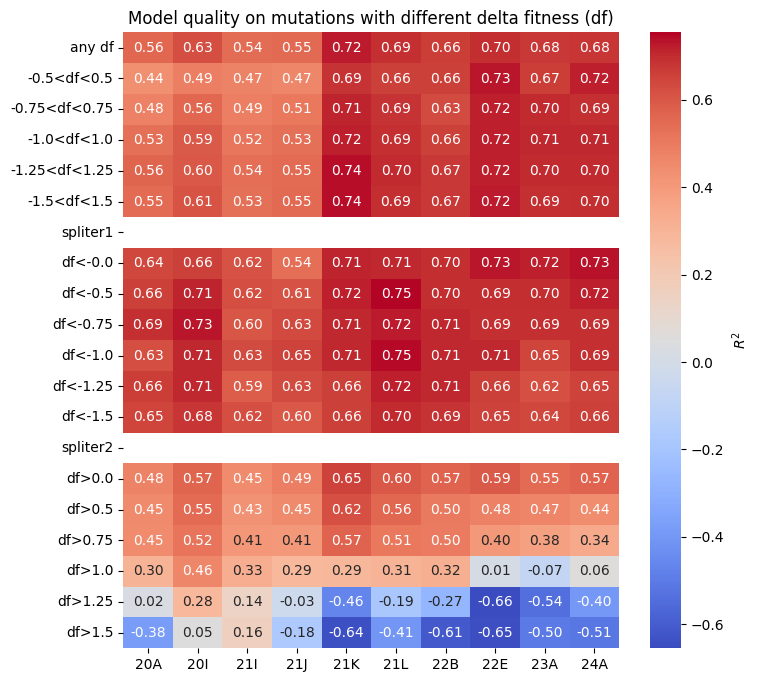

In [62]:
plt.figure(figsize=(8, 8))
_ = data_fitness_df.pivot(columns='clade', index='fitness_range', values='r2')
_ = pd.concat([_, pd.DataFrame([pd.Series(name='spliter1'), pd.Series(name='spliter2')])], axis=1).loc[order_df]
sns.heatmap(_, annot=True, fmt='.2f', 
            # cmap=sns.color_palette("light:g", as_cmap=True), 
            # cmap=sns.light_palette("seagreen", as_cmap=True),
            cmap='coolwarm',
            cbar_kws={'label': '$R^2$'}, )
plt.title('Model quality on mutations with different delta fitness (df)')
# plt.yticks(rotation=0);

Text(0.5, 0, 'Clade')

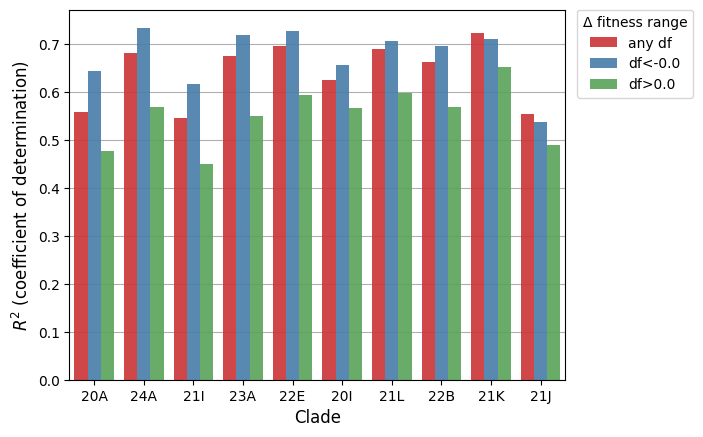

In [80]:
ax = sns.barplot(
    data_fitness_df.fillna(0).query('cutoff == 0'), 
    x='clade', y='r2', hue='fitness_range',
    palette='Set1', alpha=0.9, 
)
plt.legend(title='Δ fitness range', bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=12)
plt.xlabel('Clade', fontsize=12)

Text(0.5, 0, 'Clade')

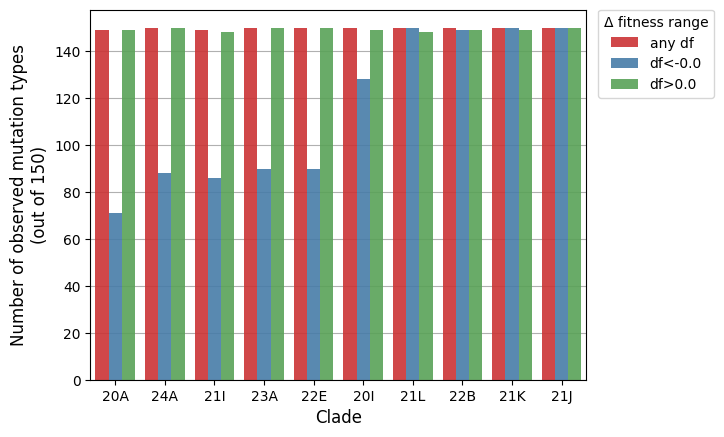

In [82]:
ax = sns.barplot(
    data_fitness_df.fillna(0).query('cutoff == 0'), 
    x='clade', y='mut_type_count', hue='fitness_range',
    palette='Set1', alpha=0.9, 
)
plt.legend(title='Δ fitness range', bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.ylabel('Number of observed mutation types\n(out of 150)', fontsize=12)
plt.xlabel('Clade', fontsize=12)

Text(0.5, 0, 'Clade')

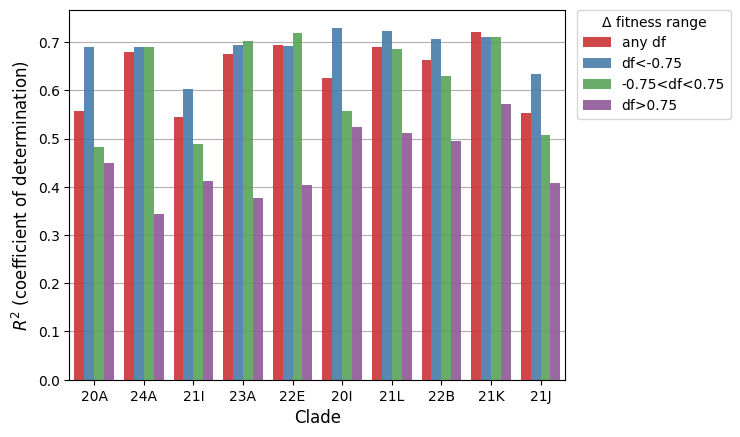

In [76]:
ax = sns.barplot(
    data_fitness_df.fillna(0.75).query('cutoff == 0.75'), 
    x='clade', y='r2', hue='fitness_range',
    palette='Set1', alpha=0.9, 
)
plt.legend(title='Δ fitness range', bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=12)
plt.xlabel('Clade', fontsize=12)

Text(0.5, 0, 'Clade')

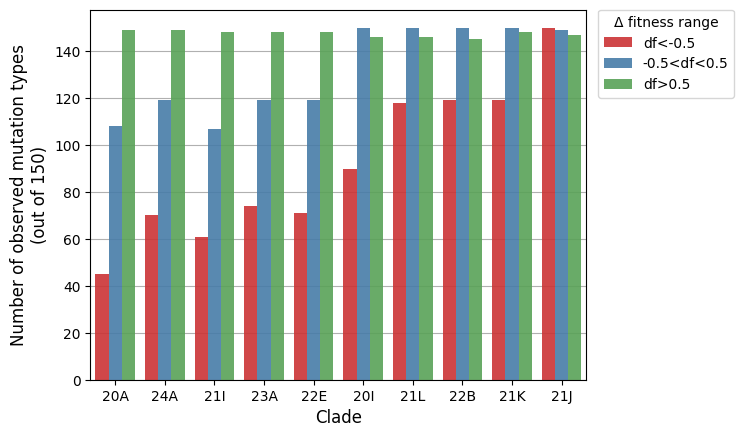

In [78]:
ax = sns.barplot(
    data_fitness_df.query('cutoff == 0.5'), 
    x='clade', y='mut_type_count', hue='fitness_range',
    palette='Set1', alpha=0.9, 
)
plt.legend(title='Δ fitness range', bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(axis='y')
ax.set_axisbelow(True)
plt.ylabel('Number of observed mutation types\n(out of 150)', fontsize=12)
plt.xlabel('Clade', fontsize=12)

Spearman correlation: 0.117 (p-value: 0.152)


/home/kpotoh/env_bio/lib/python3.9/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_11623/3755427975.py:42: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title=f"$R^2$ = {r2:.2f}", title_fontsize=14)


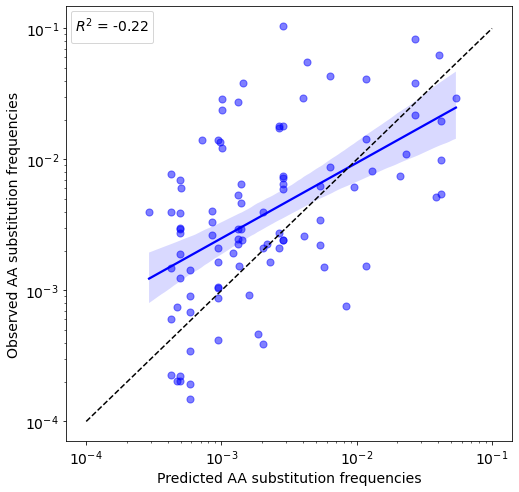

In [346]:
cutoff = 1.5
_ = aamut_fitness_ns.query(f'clade == "21J" & actual_count > 0 & delta_fitness > {cutoff}').rename(columns={'actual_count': 'count'})
aas = prepare_aa_subst(_, exp_aa_subst, aa_freqs_total_dct)
plot_subst_freqs(aas)

In [354]:
aas['ava'] = aas['nobs_freqs'].mean()
aas['res'] = (aas['nobs_freqs'] - aas['nexp_freqs'])**2
aas['tot'] = (aas['nobs_freqs'] - aas['ava'])**2
1 - aas['res'].sum() / aas['tot'].sum()

np.float64(-0.22444001433241434)

In [352]:
r2_score(aas.nobs_freqs, aas.nexp_freqs), spearmanr(aas.nobs_freqs, aas.nexp_freqs)

(-0.22444001433241434,
 SignificanceResult(statistic=np.float64(0.11744032126622556), pvalue=np.float64(0.15235292239994463)))

<Axes: xlabel='nexp_freqs', ylabel='nobs_freqs'>

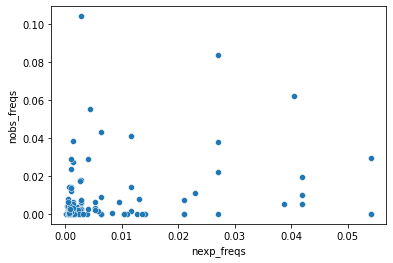

In [347]:
sns.scatterplot(aas, x='nexp_freqs', y='nobs_freqs')

<Axes: xlabel='nexp_freqs', ylabel='nobs_freqs'>

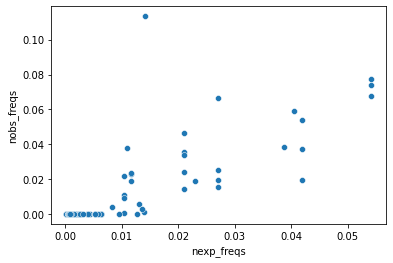

In [317]:
sns.scatterplot(aas, x='nexp_freqs', y='nobs_freqs')

## Fitness of distinct AA

In [10]:
aa_fitness = pd.read_csv('./data/bloom_etal/aa_fitness.csv')
aa_fitness

,gene,aa_site,aa,fitness,expected_count,aa_differs_among_clade_founders,subset_of_ORF1ab
0,E,1,I,-7.1032,607.410,False,False
1,E,1,K,-3.5840,17.508,False,False
2,E,1,L,-4.3124,36.811,False,False
3,E,1,M,0.0000,844.230,False,False
4,E,1,R,-3.1560,11.238,False,False
...,...,...,...,...,...,...,...
122158,nsp9,113,K,-3.4869,48.529,False,True
122159,nsp9,113,L,-2.8511,25.461,False,True
122160,nsp9,113,P,-2.0669,11.350,False,True
122161,nsp9,113,Q,0.0000,925.030,False,True


In [69]:
site_fitnesses = aa_fitness.pivot(index=['gene', 'aa_site'], columns='aa', values='fitness').fillna(0)
site_fitnesses

aa                  *        A       C      D       E       F       G  \
gene aa_site                                                            
E    1        0.00000  0.00000  0.0000  0.000  0.0000  0.0000  0.0000   
     2       -3.78190  0.00000 -5.1893 -3.156  0.0000 -2.8511  0.0000   
     3       -4.88050 -0.95878  0.0000  0.000  0.0000  0.0000  0.0000   
     4        0.00000  0.00000 -3.1560  0.000  0.0000  0.0000  0.0000   
     5        0.00000 -2.27390  0.0000 -3.584  0.0000 -2.2231 -2.0574   
...               ...      ...     ...    ...     ...     ...     ...   
nsp9 109      0.00000 -5.18930  0.0000  0.000  0.0000  0.0000  0.0000   
     110      0.00000 -5.10710  0.0000  0.000 -2.4854  0.0000 -2.0574   
     111      0.00000  0.00000 -7.2405  0.000  0.0000  0.0000 -3.5451   
     112     -0.79691  0.00000  0.0000  0.000  0.0000 -1.0741  0.0000   
     113     -5.63110  0.00000  0.0000  0.000 -2.4465  0.0000  0.0000   

aa                  H        I       K  ...    M      N       P       Q  \
gene aa_site                            ...                               
E    1        0.00000 -7.10320 -3.5840  ...  0.0  0.000  0.0000  0.0000   
     2       -2.27390  0.00000  0.0000  ...  0.0 -3.584  0.0000  0.0000   
     3        0.00000  0.00000  0.0000  ...  0.0  0.000 -0.7633  0.0000   
     4        0.00000 -2.48540  0.0000  ...  0.0  0.000  0.0000  0.0000   
     5        0.00000  0.72401  0.0000  ...  0.0  0.000  0.0000  0.0000   
...               ...      ...     ...  ...  ...    ...     ...     ...   
nsp9 109      0.00000  1.11350 -2.0206  ...  0.0  0.000 -3.1655  0.0000   
     110      0.00000 -1.46820  0.0000  ...  0.0  0.000  0.0000  0.0000   
     111     -4.85820  0.00000  0.0000  ...  0.0  0.000 -1.8907  0.0000   
     112      0.00000 -0.80668  0.0000  ...  0.0  0.000 -5.0843 -3.5662   
     113     -0.81593  0.00000 -3.4869  ...  0.0  0.000 -2.0669  0.0000   

aa                 R       S       T       V    W       Y  
gene aa_site                                               
E    1       -3.1560  0.0000 -5.1071 -4.0907  0.0  0.0000  
     2        0.0000 -3.1655  0.0000  0.0000  0.0  0.0000  
     3        0.0000  0.0000 -1.1861  0.0000  0.0  0.0000  
     4        0.0000 -3.1612  0.0000 -3.1560  0.0 -1.9745  
     5        0.0000  0.0000  0.0000  0.0000  0.0  0.0000  
...              ...     ...     ...     ...  ...     ...  
nsp9 109     -3.5451 -3.9498  0.0000  0.0000  0.0  0.0000  
     110      0.0000  0.0000  0.0000  0.0000  0.0  0.0000  
     111      0.0000 -4.5855  0.0000  0.0000  0.0  0.0000  
     112     -3.1308 -1.5527  0.0000 -2.4446  0.0  0.0000  
     113     -5.1893  0.0000  0.0000  0.0000  0.0  0.0000  

[16764 rows x 21 columns]

In [ ]:
site_fitnesses

std     min      50%      max
gene aa_site                                    
E    1        2.152015 -7.1032 -4.09070  0.00000
     2        1.480665 -5.1893 -3.16075  0.00000
     3        1.750902 -4.8805 -1.07244  0.00000
     4        1.348529 -3.1612 -2.48540  0.00000
     5        1.651020 -3.5840 -2.05740  0.72401
...                ...     ...      ...      ...
nsp9 109      2.248247 -5.1893 -3.16550  1.11350
     110      1.699352 -5.1071 -2.27140  0.00000
     111      2.307117 -7.2405 -4.26790  0.00000
     112      1.633552 -5.0843 -1.55270  0.00000
     113      1.950688 -5.6311 -2.64880  0.00000

[16764 rows x 4 columns]

In [114]:
X_descr = aa_fitness.query('aa != "*" & fitness != 0')\
    .groupby(['gene', 'aa_site'])['fitness'].describe().join(
        aa_fitness.query('aa != "*"').groupby(['gene', 'aa_site'])\
            ['fitness'].max().rename('max=0') == 0)

In [115]:
X_descr

count      mean       std     min       25%      50%       75%  \
gene aa_site                                                                   
E    1          6.0 -4.558900  1.412269 -7.1032 -4.908425 -4.20155 -3.710675   
     2          6.0 -3.369967  0.991358 -5.1893 -3.479375 -3.16075 -2.927325   
     3          4.0 -1.350945  0.782417 -2.4956 -1.513475 -1.07244 -0.909910   
     4          6.0 -2.383348  1.099300 -3.1612 -3.156000 -2.82070 -2.102225   
     5          6.0 -1.498047  1.698920 -3.5840 -2.261200 -2.14025 -0.194767   
...             ...       ...       ...     ...       ...      ...       ...   
nsp9 109        6.0 -2.792800  2.174497 -5.1893 -3.848625 -3.35530 -2.306825   
     110        5.0 -2.825300  1.395265 -5.1071 -3.008400 -2.48540 -2.057400   
     111        6.0 -4.397983  1.752579 -7.2405 -4.790025 -4.42670 -3.725800   
     112        7.0 -2.522769  1.528106 -5.0843 -3.348500 -2.44460 -1.313400   
     113        6.0 -2.809438  1.468441 -5.1893 -3.327950 -2.64880 -2.161800   

                  max  max=0  
gene aa_site                  
E    1       -3.15600   True  
     2       -2.27390   True  
     3       -0.76330   True  
     4       -0.36699   True  
     5        0.72401  False  
...               ...    ...  
nsp9 109      1.11350  False  
     110     -1.46820   True  
     111     -1.89070   True  
     112     -0.80668   True  
     113     -0.81593   True  

[16764 rows x 9 columns]

In [116]:
X_descr['count'].value_counts()

count
6.0     10663
7.0      2731
5.0      2171
4.0       964
9.0       126
10.0       44
8.0        32
11.0       14
3.0         8
13.0        5
12.0        5
14.0        1
Name: count, dtype: int64

<Axes: >

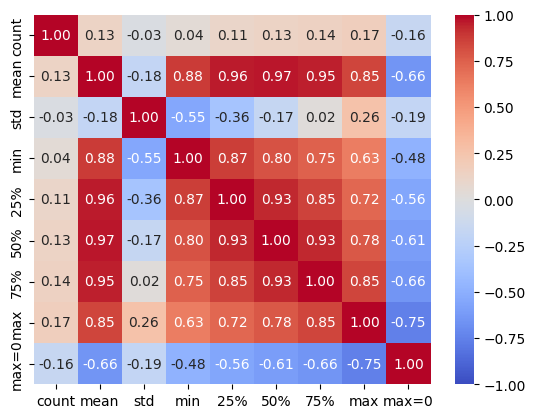

In [117]:
sns.heatmap(X_descr.corr(), annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)

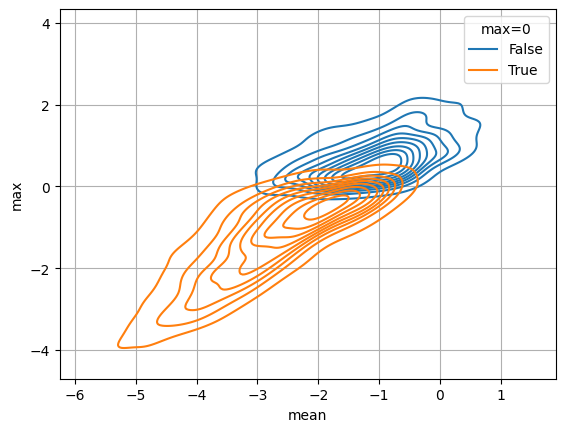

In [ ]:
# sns.kdeplot(X_descr, x='mean', y='max')
sns.kdeplot(X_descr.sample(frac=0.1), x='mean', y='max', hue='max=0')
# plt.ylim(-1, 2)
plt.grid()

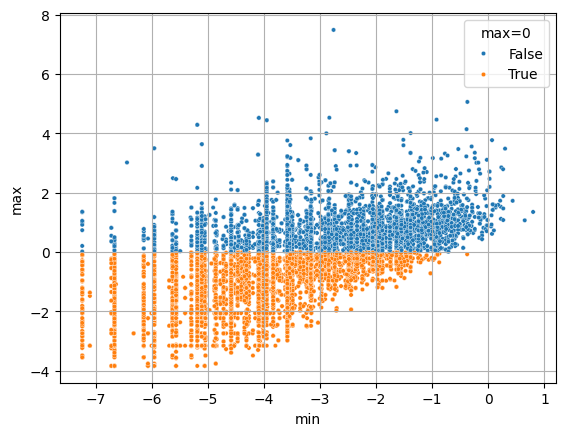

In [ ]:
sns.scatterplot(X_descr, x='min', y='max', hue='max=0', s=10)
plt.grid()

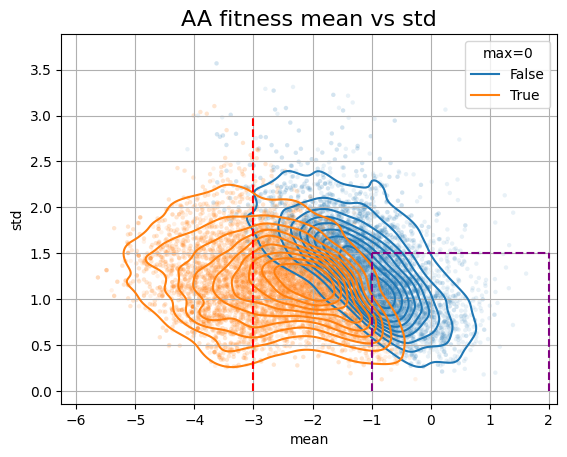

In [ ]:
frac=0.5
# sns.scatterplot(X_descr.sample(frac=frac), x='mean', y='std', hue='max=0', alpha=0.1, s=10)
# sns.kdeplot(X_descr.sample(frac=frac), x='mean', y='std', hue='max=0')

sns.scatterplot(X_descr, x='mean', y='std', hue='max=0', alpha=0.1, s=10)
sns.kdeplot(X_descr, x='mean', y='std', hue='max=0')
plt.title('AA fitness mean vs std', fontsize=16)
# plt.plot([-3, 0], [0, 3])
plt.vlines([-1, 2], 0, 1.5, color='purple', linestyle='--', label='plateau')
plt.hlines([0, 1.5], -1, 2, color='purple', linestyle='--', label='plateau')
plt.vlines([-3], 0, 3, color='red', linestyle='--', label='peak')
plt.grid()

In [162]:
# Sharp peaks
# X_descr.query('mean < -3')
# sites_plateau = X_descr.query('-1 < mean < 1 & std < 1.5')

X_descr['landscape_char'] = 'none'
X_descr.loc[(X_descr['mean'] < -3)&(X_descr['max=0']), 'landscape_char'] = 'rock'
X_descr.loc[(X_descr['mean'] > -3)&(X_descr['max=0']), 'landscape_char'] = 'hill'
X_descr.loc[(X_descr['mean'].between(-1, 2 ))&(X_descr['std'] < 1.5), 'landscape_char'] = 'plateau'
X_descr.loc[(X_descr['mean'].between(-3, -1))&(~X_descr['max=0']), 'landscape_char'] = 'climb'

In [163]:
X_descr.landscape_char.value_counts()

landscape_char
hill       6233
rock       3465
climb      3431
plateau    3130
none        505
Name: count, dtype: int64

Text(0.5, 0, 'mean (mount height)')

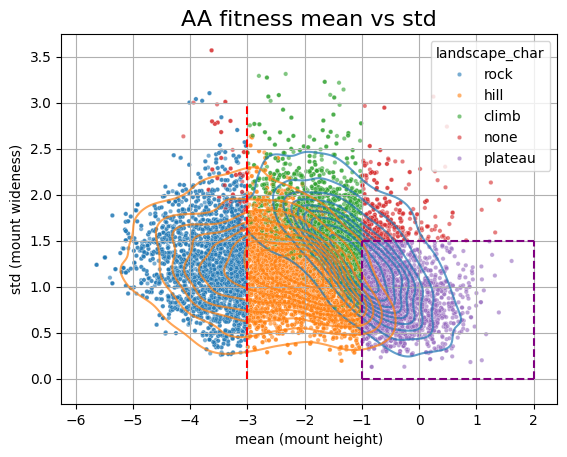

In [169]:
sns.kdeplot(X_descr.sample(frac=0.1), x='mean', y='std', hue='max=0', alpha=0.7)
sns.scatterplot(X_descr, x='mean', y='std', hue='landscape_char', alpha=0.6, s=10)
plt.title('AA fitness mean vs std', fontsize=16)
# plt.plot([-3, 0], [0, 3])
plt.vlines([-1, 2], 0, 1.5, color='purple', linestyle='--', label='plateau')
plt.hlines([0, 1.5], -1, 2, color='purple', linestyle='--', label='plateau')
plt.vlines([-3], 0, 3, color='red', linestyle='--', label='peak')
plt.grid()
plt.ylabel('std (mount wideness)')
plt.xlabel('mean (mount height)')

In [173]:
X_descr[['landscape_char']].to_csv('./data/sites_landscape_labels.csv')

In [188]:
aamut_fitness_ns_lbl = aamut_fitness_ns.merge(X_descr[['landscape_char']].reset_index())
aamut_fitness_ns_lbl

,clade,gene,clade_founder_aa,mutant_aa,aa_site,aa_mutation,expected_count,actual_count,count_terminal,count_non_terminal,mean_log_size,subset_of_ORF1ab,delta_fitness,aa1,aa2,landscape_char
0,20A,E,A,D,22,A22D,0.67725,0,0,0,0.0,False,-0.85633,A,D,hill
1,20A,E,A,D,32,A32D,0.67725,0,0,0,0.0,False,-0.85633,A,D,rock
2,20A,E,A,E,36,A36E,0.67725,0,0,0,0.0,False,-0.85633,A,E,rock
3,20A,E,A,E,41,A41E,0.67725,0,0,0,0.0,False,-0.85633,A,E,hill
4,20A,E,A,G,22,A22G,0.23810,0,0,0,0.0,False,-0.38947,A,G,hill
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2375634,24A,nsp1,Y,D,97,Y97D,0.25363,0,0,0,0.0,True,-0.41029,Y,D,hill
2375635,24A,nsp1,Y,F,97,Y97F,0.77908,0,0,0,0.0,True,-0.93929,Y,F,hill
2375636,24A,nsp1,Y,H,97,Y97H,2.17910,0,0,0,0.0,True,-1.67860,Y,H,hill
2375637,24A,nsp1,Y,N,97,Y97N,0.48805,0,0,0,0.0,True,-0.68113,Y,N,hill


In [189]:
aamut_fitness_ns_lbl.groupby('landscape_char').actual_count.sum()

landscape_char
climb      1510758
hill       1080377
none        378210
plateau    1986057
rock        103662
Name: actual_count, dtype: int64

In [202]:
data_fitness_sites = []
for clade in clades_mut_cnt[clades_mut_cnt>100000].index:
    print(clade)
    spectrum_cur = clades_spectra[clades_spectra['clade'] == clade].copy()
    spectrum_cur['rate'] /= spectrum_cur['rate'].sum()

    spectrum_dct = spectrum_cur.set_index('Mut').rate.to_dict()
    df_changes = collect_possible_changes(1, spectrum_dct)
    exp_aa_subst_cur = df_changes[(df_changes.aa1 != '*')&(df_changes.aa2 != '*')]\
        .groupby(['aa1', 'aa2'])['rate'].sum().reset_index()

    for lchar in aamut_fitness_ns_lbl.landscape_char.unique():

        _ = aamut_fitness_ns_lbl\
            .query(f'clade == "{clade}" & actual_count > 0 & landscape_char == "{lchar}"')\
                .rename(columns={'actual_count': 'count'})
        aas = prepare_aa_subst(_, exp_aa_subst_cur, aa_freqs_total_dct)
        cur_met = calc_metrics(aas)
        data_fitness_sites.append({
            'clade': clade,
            'landscape_char': lchar,
            'r2': cur_met['r2'], 
            'spearman_corr': cur_met['spearman_corr'], 
            'mut_count': cur_met['mut_count'], 
            'mut_type_count': aas.nobs.ne(0).sum(), 
        })

data_fitness_sites_df = pd.DataFrame(data_fitness_sites)

20A
24A
21I
23A
22E
20I
21L
22B
21K
21J


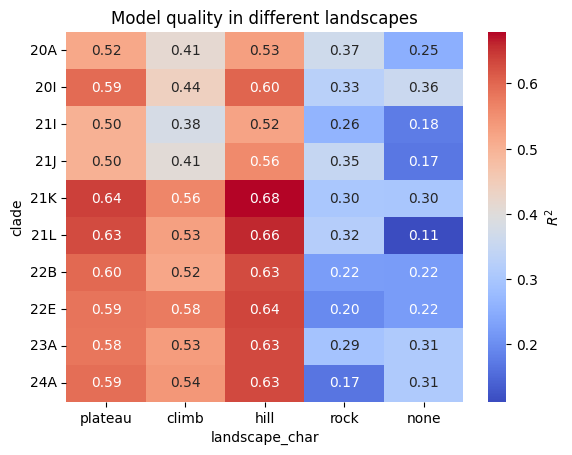

In [227]:
_ = data_fitness_sites_df.pivot(index='clade', columns='landscape_char', values='r2')\
        [['plateau', 'climb', 'hill', 'rock', 'none']]
sns.heatmap(_, annot=True, fmt='.2f', cmap='coolwarm', cbar_kws={'label': '$R^2$'})
plt.title('Model quality in different landscapes')
plt.yticks(rotation=0);

## VIZ of computed metrics

In [ ]:
metrics_total_df = pd.read_csv('data/fit_metrics_sites.csv')\
    .set_index(['clade', 'branches', 'sites_sample', 'sample_cutoff'])
metrics_total_df

r2     mape      wape  \
clade branches     sites_sample   sample_cutoff                                
20A   all          total          10             0.554192  1.40381  0.581897   
      terminal     total          10             0.555854  1.50038  0.577490   
      non-terminal total          10             0.549590  2.28411  0.594660   
      all          most variable  10             0.351581  4.17617  0.758060   
                   least variable 10            -1.456220  1.44878  1.034450   
...                                                   ...      ...       ...   
24A   all          least variable 20            -1.479950  1.36420  0.981621   
                   random         20             0.628768  1.01184  0.548030   
                   most variable  30             0.590548  1.50023  0.618470   
                   least variable 30            -1.793850  1.55717  0.992660   
                   random         30             0.765515  1.65799  0.496825   

                                                    slope  intercept  \
clade branches     sites_sample   sample_cutoff                        
20A   all          total          10             0.690693   0.002062   
      terminal     total          10             0.703542   0.001976   
      non-terminal total          10             0.670791   0.002195   
      all          most variable  10             0.606556   0.002623   
                   least variable 10             0.492400   0.003384   
...                                                   ...        ...   
24A   all          least variable 20             0.571173   0.002859   
                   random         20             0.831344   0.001124   
                   most variable  30             0.781316   0.001458   
                   least variable 30             0.507294   0.003285   
                   random         30             0.884978   0.000767   

                                                 spearman_corr    spearman_p  \
clade branches     sites_sample   sample_cutoff                                
20A   all          total          10                  0.789971  2.992510e-33   
      terminal     total          10                  0.792167  1.501260e-33   
      non-terminal total          10                  0.779495  7.199340e-32   
      all          most variable  10                  0.661023  3.408810e-20   
                   least variable 10                  0.527477  4.055630e-12   
...                                                        ...           ...   
24A   all          least variable 20                  0.563644  5.935820e-14   
                   random         20                  0.736847  6.082340e-27   
                   most variable  30                  0.735541  8.313290e-27   
                   least variable 30                  0.563577  5.985170e-14   
                   random         30                  0.758069  2.884570e-29   

                                                 pearson_corr     pearson_p  \
clade branches     sites_sample   sample_cutoff                               
20A   all          total          10                 0.759419  2.014550e-29   
      terminal     total          10                 0.762547  8.687700e-30   
      non-terminal total          10                 0.753749  8.957950e-29   
      all          most variable  10                 0.653484  1.253520e-19   
                   least variable 10                 0.315161  8.557840e-05   
...                                                       ...           ...   
24A   all          least variable 20                 0.352718  9.560540e-06   
                   random         20                 0.817593  2.641770e-37   
                   most variable  30                 0.792456  1.370270e-33   
                   least variable 30                 0.302710  1.664560e-04   
                   random         30                 0.883019  1.774000e-50   

        

In [27]:
metrics_total_df.reset_index().query('sites_sample == "total" & branches == "all"')\
    .set_index('clade')[['r2','slope', 'spearman_corr', 'mut_count']].round(2)

,r2,slope,spearman_corr,mut_count
clade,,,,
20A,0.55,0.69,0.79,65022
20B,0.53,0.70,0.77,54119
20C,0.57,0.70,0.78,54374
20E,0.65,0.71,0.77,36788
20G,0.61,0.70,0.77,50615
20I,0.63,0.70,0.76,209841
20J,0.53,0.67,0.76,16493
21C,0.63,0.72,0.77,22846
21I,0.55,0.69,0.78,82824


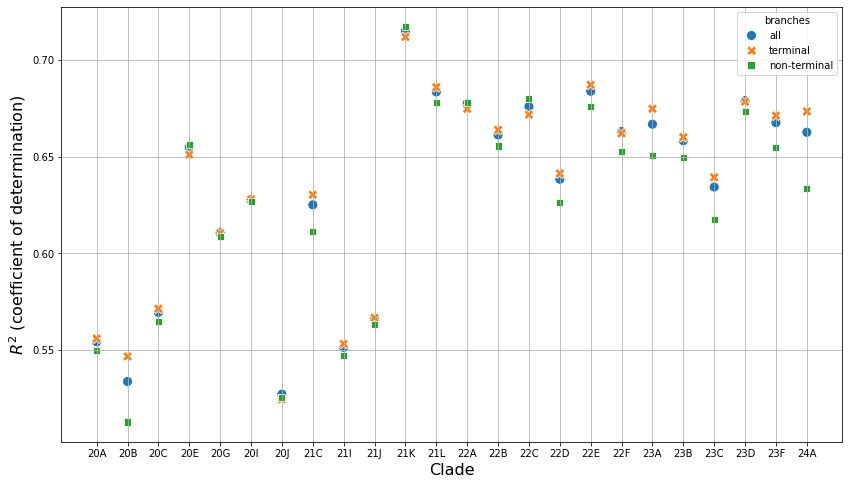

In [98]:
plt.figure(figsize=(14, 8))
_ = metrics_total_df.reset_index().query('sites_sample == "total"')
sns.scatterplot(_, hue='branches', y='r2', x='clade', style='branches', s=100)
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=16)
plt.xlabel('Clade', fontsize=16)
plt.grid()

/tmp/ipykernel_11623/2260375007.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(_, x='branches', y='r2', palette='Set2')


Text(0.5, 0, 'Branches')

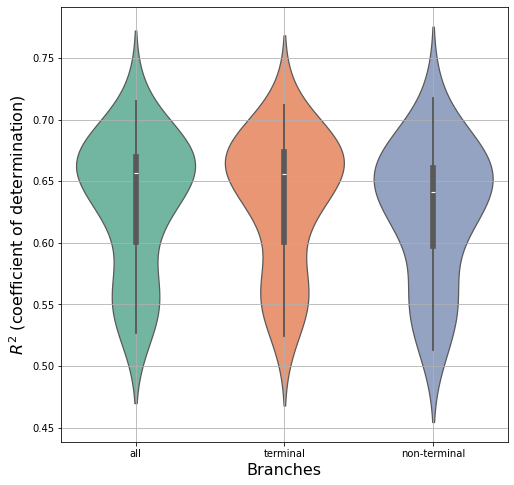

In [55]:
_ = metrics_total_df.reset_index().query('sites_sample == "total"')
plt.figure(figsize=(8, 8))
sns.violinplot(_, x='branches', y='r2', palette='Set2')
plt.grid()
plt.ylabel('$R^2$ (coefficient of determination)', fontsize=16)
plt.xlabel('Branches', fontsize=16)

In [25]:
_

,clade,branches,sites_sample,sample_cutoff,r2,mape,wape,slope,intercept,spearman_corr,spearman_p,pearson_corr,pearson_p,ks_stat,ks_p,rmse,log_likelihood,mut_count
0,20A,all,total,10,0.554192,1.40381,0.581897,0.690693,0.002062,0.789971,2.992510e-33,0.759419,2.014550e-29,0.120000,0.230782,0.008265,-5.36878,65022
1,20A,terminal,total,10,0.549590,2.28411,0.594660,0.670791,0.002195,0.779495,7.199340e-32,0.753749,8.957950e-29,0.126667,0.180395,0.008490,-5.34130,26936
2,20A,non-terminal,total,10,0.549590,2.28411,0.594660,0.670791,0.002195,0.779495,7.199340e-32,0.753749,8.957950e-29,0.126667,0.180395,0.008490,-5.34130,26936
12,20B,all,total,10,0.533618,1.64761,0.593804,0.702346,0.001984,0.771259,7.784420e-31,0.752530,1.228320e-28,0.126667,0.180395,0.008405,-5.38466,54119
13,20B,terminal,total,10,0.512645,2.23583,0.617270,0.682948,0.002114,0.749610,2.596310e-28,0.739349,3.325940e-27,0.106667,0.361727,0.008681,-5.38826,22367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,23F,terminal,total,10,0.654933,1.21219,0.562436,0.808392,0.001277,0.780490,5.362840e-32,0.824267,2.179150e-38,0.080000,0.724957,0.006484,-5.44324,15340
266,23F,non-terminal,total,10,0.654933,1.21219,0.562436,0.808392,0.001277,0.780490,5.362840e-32,0.824267,2.179150e-38,0.080000,0.724957,0.006484,-5.44324,15340
276,24A,all,total,10,0.662644,1.19427,0.573765,0.781711,0.001455,0.758251,2.748880e-29,0.823640,2.767570e-38,0.066667,0.894321,0.007082,-5.39798,65550
277,24A,terminal,total,10,0.633569,1.20314,0.602122,0.735849,0.001761,0.742148,1.678740e-27,0.803773,3.396300e-35,0.093333,0.532187,0.007652,-5.38888,20596


In [21]:
metrics_total_df.query('sites_sample == "total" & branches == "all"').r2.mean()

np.float64(0.632802)

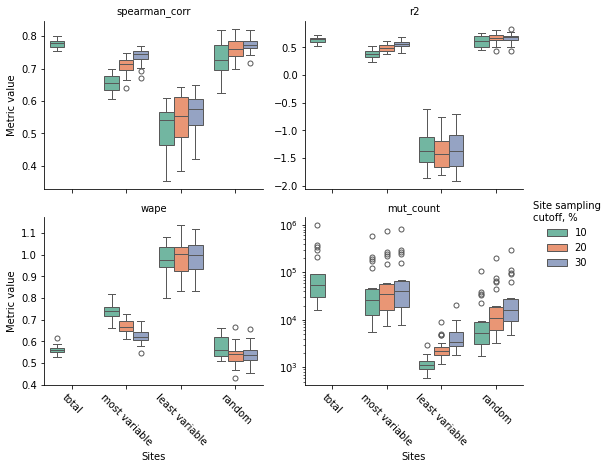

In [5]:
_ = metrics_total_df[['spearman_corr','r2', 'wape', 'mut_count']]\
    .melt(ignore_index=False, var_name='metric').reset_index()
g = sns.catplot(data=_, sharey=False, kind='box', col='metric', col_wrap=2,
                y='value', x='sites_sample', hue='sample_cutoff',  
                palette='Set2', height=3, aspect=1.25,
                # col_order=['accuracy']
)
g.set_titles('{col_name}')
g.set_xticklabels(g.axes[2].get_xticklabels(), rotation=-45)
g.set_xlabels('Sites')
g.set_ylabels('Metric value')
g.axes_dict['mut_count'].set_yscale('log')
g.legend.set_title('Site sampling\ncutoff, %')
g.savefig('./figures/clades_fit_metrics_boxplots.pdf')

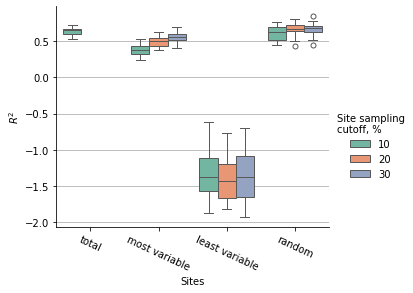

In [6]:
# _ = metrics_total_df[['spearman_corr','r2']]\
_ = metrics_total_df[['r2']]\
    .melt(ignore_index=False, var_name='metric').reset_index()
g = sns.catplot(data=_, sharey=False, kind='box', col='metric', col_wrap=1,
                y='value', x='sites_sample', hue='sample_cutoff',  
                palette='Set2', height=4, aspect=1.2,
                # col_order=['accuracy']
)
g.set_titles('')
g.set_xticklabels(g.axes[0].get_xticklabels(), rotation=-25)
g.set_xlabels('Sites')
g.set_ylabels('$R^2$')
g.legend.set_title('Site sampling\ncutoff, %')
plt.grid(axis='y')
# g.savefig('./figures/clades_fit_metrics_boxplots.pdf')

In [7]:
metrics_total_df.sort_values('mut_count').tail(10)

r2     mape      wape     slope  \
clade sites_sample  sample_cutoff                                          
22B   most variable 30             0.601283  1.64626  0.608386  0.758498   
21J   random        30             0.683558  1.22905  0.535570  0.759576   
21K   most variable 30             0.693536  1.50510  0.547090  0.806274   
21L   total         10             0.680218  1.27643  0.546289  0.781451   
22B   total         10             0.652389  1.29013  0.564285  0.756868   
21K   total         10             0.714426  1.28275  0.526022  0.815096   
21J   most variable 10             0.452771  7.38623  0.696045  0.604544   
                    20             0.489766  2.54696  0.646226  0.680757   
                    30             0.545681  1.74270  0.589033  0.716201   
      total         10             0.541930  1.36622  0.576756  0.708915   

                                   intercept  spearman_corr    spearman_p  \
clade sites_sample  sample_cutoff                                           
22B   most variable 30              0.001610       0.751219  1.720860e-28   
21J   random        30              0.001603       0.817630  2.606140e-37   
21K   most variable 30              0.001292       0.754548  7.276820e-29   
21L   total         10              0.001457       0.771696  6.877510e-31   
22B   total         10              0.001621       0.769430  1.303050e-30   
21K   total         10              0.001233       0.760432  1.536240e-29   
21J   most variable 10              0.002636       0.690098  1.549390e-22   
                    20              0.002128       0.740773  2.351000e-27   
                    30              0.001892       0.768110  1.884840e-30   
      total         10              0.001941       0.786055  1.003370e-32   

                                   pearson_corr     pearson_p   ks_stat  \
clade sites_sample  sample_cutoff                                         
22B   most variable 30                 0.792638  1.293450e-33  0.086667   
21J   random        30                 0.830947  1.610030e-39  0.080000   
21K   most variable 30                 0.841051  2.500820e-41  0.086667   
21L   total         10                 0.831762  1.162740e-39  0.073333   
22B   total         10                 0.815513  5.630560e-37  0.093333   
21K   total         10                 0.851759  2.176000e-43  0.066667   
21J   most variable 10                 0.695146  5.689860e-23  0.220000   
                    20                 0.729116  3.764460e-26  0.126667   
                    30                 0.760574  1.478930e-29  0.100000   
      total         10                 0.757473  3.377820e-29  0.093333   

                                       ks_p      rmse  log_likelihood  \
clade sites_sample  sample_cutoff                                       
22B   most variable 30             0.627917  0.007463        -5.40155   
21J   random        30             0.724957  0.006684        -5.31596   
21K   most variable 30             0.627917  0.006666        -5.35438   
21L   total         10             0.816483  0.007058        -5.35215   
22B   total         10             0.532187  0.007185        -5.38509   
21K   total         10             0.894321  0.006446        -5.37454   
21J   most variable 10             0.001358  0.009239        -5.31093   
                    20             0.180395  0.008310        -5.36937   
                    30             0.442524  0.007775        -5.37089   
      total         10             0.532187  0.007855        -5.41288   

                                   mut_count  
clade sites_sample  sample_cutoff             
22B   most variable 30                270730  
21J   random        30                299157  
21K   most variable 30                302072  
21L   total         10                303058  
22B   total         10                336039  
21K   total         10                379211  
21J   most variable 10                581338  
  

## Random model on clades 

In [9]:
metrics_rnd_df = pd.read_csv('data/fit_metrics_rnd.csv', index_col=[0,1,2])
metrics_rnd_df

r2     mape      wape     slope  intercept  \
model   clade replica                                                     
neutral 20A   1        0.561227  1.36992  0.587019  0.720492   0.001863   
random  20A   1       -0.135155  5.70277  1.143140 -0.018587   0.006791   
              2       -0.044220  5.45900  1.065530  0.048420   0.006344   
              3       -0.037847  6.05870  1.076770  0.041152   0.006392   
              4       -0.049133  4.67094  1.077770  0.064110   0.006239   
...                         ...      ...       ...       ...        ...   
        24A   16       0.007303  6.35617  1.015100  0.045311   0.006365   
              17       0.030088  7.51860  1.009970  0.089760   0.006068   
              18      -0.098874  7.42605  1.108490  0.019444   0.006537   
              19      -0.164259  5.03905  1.075310 -0.006853   0.006712   
              20      -0.342587  6.42130  1.171000 -0.034350   0.006896   

                       spearman_corr    spearman_p  pearson_corr  \
model   clade replica                                              
neutral 20A   1             0.789782  3.173920e-33      0.768153   
random  20A   1             0.014748  8.578410e-01     -0.059379   
              2             0.164345  4.446830e-02      0.128920   
              3             0.120957  1.403640e-01      0.118721   
              4             0.233528  4.026630e-03      0.152233   
...                              ...           ...           ...   
        24A   16            0.228623  4.892940e-03      0.156975   
              17            0.244165  2.603110e-03      0.232200   
              18            0.032972  6.887520e-01      0.052387   
              19            0.202097  1.313400e-02     -0.017662   
              20            0.020489  8.034690e-01     -0.065636   

                          pearson_p   ks_stat          ks_p      rmse  \
model   clade replica                                                   
neutral 20A   1        1.862200e-30  0.126667  1.803950e-01  0.008200   
random  20A   1        4.704180e-01  0.466667  3.994110e-15  0.013189   
              2        1.158810e-01  0.413333  7.435540e-12  0.012650   
              3        1.479010e-01  0.406667  1.771160e-11  0.012611   
              4        6.292490e-02  0.353333  1.044100e-08  0.012679   
...                             ...       ...           ...       ...   
        24A   16       5.506370e-02  0.440000  1.965830e-13  0.012149   
              17       4.246400e-03  0.393333  9.582440e-11  0.012008   
              18       5.243370e-01  0.360000  4.964600e-09  0.012782   
              19       8.301390e-01  0.333333  8.870020e-08  0.013157   
              20       4.248620e-01  0.220000  1.357880e-03  0.014128   

                       log_likelihood  mut_count  
model   clade replica                             
neutral 20A   1              -5.37332      65022  
random  20A   1              -6.19734      65022  
              2              -5.99208      65022  
              3              -6.02072      65022  
              4              -6.57942      65022  
...                               ...        ...  
        24A   16             -5.95878      65550  
              17             -5.95938      65550  
              18             -6.09729      65550  
              19             -6.23207      65550  
              20             -7.10441      65550  

[504 rows x 14 columns]

/tmp/ipykernel_48045/624859558.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(data=_, sharey=False, kind='box', col='metric',


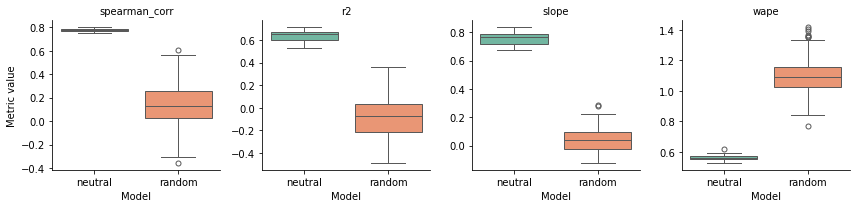

In [10]:
_ = metrics_rnd_df[['spearman_corr', 'r2', 'slope', 'wape']]\
    .melt(ignore_index=False, var_name='metric').reset_index()
g = sns.catplot(data=_, sharey=False, kind='box', col='metric', 
                y='value', x='model', palette='Set2', height=3, aspect=1,
)
g.set_titles('{col_name}')
# g.set_xticklabels(g.axes[2].get_xticklabels(), rotation=-45)
g.set_xlabels('Model')
g.set_ylabels('Metric value')
g.savefig('./figures/rnd_fit_metrics_boxplots.pdf')


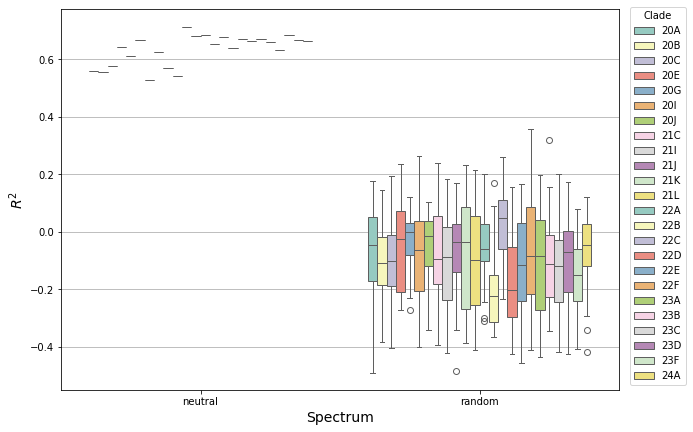

In [ ]:
plt.figure(figsize=(10, 7))
ax = sns.boxplot(data=metrics_rnd_df.reset_index(), 
                y='r2', x='model', hue='clade',
                palette='Set3',
)
ax.set_xlabel('Spectrum', fontsize=14)
ax.set_ylabel('$R^2$', fontsize=14)
plt.legend(title='Clade', bbox_to_anchor=(1.01, 1.02), loc='upper left')
plt.grid(axis='y')
plt.savefig('./figures/fit_metrics_rnd.pdf')